<a href="https://colab.research.google.com/github/AHMerrill/unstructured-data-2/blob/main/Unstructured_Assignment_2_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unstructured Assignment 2: Building a Crowdsourced Recommender System

In [ ]:
# Install specific versions of gensim and numpy that are likely compatible
!pip install gensim==4.3.0 numpy==1.23.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 84.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 40.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
# IMPORTS NEEDED FOR TASKS
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import numpy as np
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import matplotlib.pyplot as plt

import spacy

In [ ]:
from gensim.models import Word2Vec
from numpy.linalg import norm


# TASK A

## Scraper toggle for Colab or Local

## You have to change "LOCAL" below to "COLAB" if you want to run this on colab

### Note: Our team ran this locally, and it takes a very long time to scrape all the reviews.  We know that it works locally, but have not had the opportunity to run a full test on colab.  recommend downloading and running locally

In [ ]:
# =========================
# Cell 0: Environment Mode
# =========================
# Purpose:
# - Choose where you’re running: your local machine (GUI Chrome) or Google Colab (headless).
# - In COLAB, install Chrome/Chromedriver only if missing.
# - Optionally mount Google Drive and set the output base there.

MODE = "LOCAL"         # change to "COLAB" when running in Google Colab
OUTPUT_BASE = "./beeradvocate_out"   # will be used later; override after mounting Drive if desired

if MODE == "COLAB":
    import os, shutil, subprocess, sys

    def sh(cmd):
        print(f"$ {cmd}")
        out = subprocess.check_output(cmd, shell=True, text=True, stderr=subprocess.STDOUT)
        print(out)

    # Check if Chrome and Chromedriver are already present
    chrome_ok = shutil.which("google-chrome") is not None
    cdriver_ok = os.path.exists("/usr/local/bin/chromedriver")

    if not chrome_ok or not cdriver_ok:
        print("Chrome or Chromedriver missing; installing...")
        sh("apt-get update")
        sh("apt-get install -y wget unzip")
        sh("wget -q https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb")
        sh("apt install -y ./google-chrome-stable_current_amd64.deb")
        # Match Chrome version
        chrome_version = subprocess.check_output("google-chrome --version | awk '{print $3}'", shell=True, text=True).strip()
        url = f"https://storage.googleapis.com/chrome-for-testing-public/{chrome_version}/linux64/chromedriver-linux64.zip"
        sh(f"wget -q '{url}' -O /tmp/chromedriver.zip")
        sh("unzip -o /tmp/chromedriver.zip -d /tmp")
        sh("mv -f /tmp/chromedriver-linux64/chromedriver /usr/local/bin/chromedriver")
        sh("chmod +x /usr/local/bin/chromedriver")
    else:
        print("Chrome + Chromedriver already installed; skipping setup.")

    # Optional: mount Drive for persistent outputs
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        # Example: uncomment to write outputs to Drive
        # OUTPUT_BASE = "/content/drive/MyDrive/beeradvocate_out"
    except Exception:
        pass

print(f"MODE: {MODE}")
print(f"OUTPUT_BASE: {OUTPUT_BASE}")


MODE: LOCAL
OUTPUT_BASE: ./beeradvocate_out


## Basic Setup
### Note: my login information to beeradvocate.com is hard-coded here, please don't abuse it

In [ ]:
# =========================
# Cell 1: Setup & Helpers
# =========================
# Purpose:
# - Import libraries and set constants (URLs, creds).
# - Start Chrome differently for LOCAL vs COLAB.
# - Configure shorter timeouts to avoid long hangs.
# - Enable CDP navigation (go()) to avoid ChromeDriver read timeouts.
# - Provide small helpers for interacting with the login form reliably.

import os, re, time, random
import pandas as pd
from urllib.parse import urljoin, urlsplit, urlunsplit, urlencode

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

# URLs and credentials
LOGIN_URL     = "https://www.beeradvocate.com/community/login/"
TOP_RATED_URL = "https://www.beeradvocate.com/beer/top-rated/"
BA_USER = os.environ.get("BA_USER", "ahmerrill@gmail.com")
BA_PASS = os.environ.get("BA_PASS", "beerproject123$")

def build_chrome_options(mode: str) -> webdriver.ChromeOptions:
    """Create ChromeOptions tuned for reliability. COLAB uses headless; LOCAL is visible."""
    opts = webdriver.ChromeOptions()
    if mode == "COLAB":
        opts.add_argument("--headless=new")
    opts.add_argument("--no-sandbox")
    opts.add_argument("--disable-dev-shm-usage")
    opts.add_argument("--disable-gpu")
    opts.add_argument("--window-size=1280,900")
    # Return after DOMContentLoaded; faster and avoids waiting on slow subresources
    opts.set_capability("pageLoadStrategy", "eager")
    return opts

def start_driver(mode: str) -> webdriver.Chrome:
    """Start Chrome for LOCAL or COLAB and set sane timeouts + enable CDP Page domain."""
    options = build_chrome_options(mode)
    if mode == "LOCAL":
        # Try common paths for a locally installed chromedriver
        chromedriver_paths = [
            "/usr/local/bin/chromedriver",
            "/opt/homebrew/bin/chromedriver",
            "./chromedriver",
            "chromedriver",
        ]
        last_err = None
        drv = None
        for path in chromedriver_paths:
            try:
                service = Service(path)
                drv = webdriver.Chrome(service=service, options=options)
                break
            except Exception as e:
                last_err = e
        if drv is None:
            raise RuntimeError(f"Could not start Chrome locally: {last_err}")
    else:
        # In Colab, we install to /usr/local/bin/chromedriver in Cell 0
        service = Service("/usr/local/bin/chromedriver")
        drv = webdriver.Chrome(service=service, options=options)

    # Avoid long hangs on bad pages or scripts
    drv.set_page_load_timeout(45)   # we mostly avoid driver.get, but set for safety
    drv.set_script_timeout(30)      # JS execution timeouts

    # Shorten the ChromeDriver HTTP client timeouts (non-deprecated fields)
    cfg = drv.command_executor._client_config
    cfg.timeout = 45
    cfg.keep_alive = False

    # Enable CDP Page domain so we can navigate without driver.get
    try:
        drv.execute_cdp_cmd("Page.enable", {})
    except Exception:
        pass
    return drv

# Create the driver using MODE from Cell 0
driver = start_driver(MODE)
print("Chrome started successfully.")

# -------- Helpers for the login form and reliable input filling

def click_registered_radio(driver):
    """Toggle the 'I have a password' radio with multiple selectors (XenForo variants)."""
    candidates = [
        (By.ID, "ctrl_registered"),
        (By.CSS_SELECTOR, "input[type='radio'][name='register'][id*='registered']"),
        (By.XPATH, "//input[@type='radio' and @name='register' and contains(@id,'registered')]"),
        (By.XPATH, "//*[@id='pageLogin']//label[contains(., 'Yes, my password')]"),
    ]
    for by, sel in candidates:
        try:
            el = WebDriverWait(driver, 6).until(EC.element_to_be_clickable((by, sel)))
            driver.execute_script("arguments[0].scrollIntoView({block:'center'});", el)
            el.click()
            time.sleep(0.4)
            return True
        except Exception:
            pass
    return False

def first_displayed(drv, locators):
    """Return the first element among locators that exists and is visible."""
    for by, sel in locators:
        try:
            els = drv.find_elements(by, sel)
            for el in els:
                if el.is_displayed():
                    return el
        except Exception:
            pass
    return None

def set_value_with_verification(drv, el, text):
    """Type into an input; fall back to JS if blocked; verify the value stuck."""
    try:
        drv.execute_script("arguments[0].scrollIntoView({block:'center'});", el)
        WebDriverWait(drv, 5).until(EC.element_to_be_clickable(el))
    except Exception:
        pass
    try:
        el.clear()
        el.click()
        el.send_keys(text)
        time.sleep(0.3)
    except Exception:
        # Force visibility/state and set via JS + dispatch typical form events
        drv.execute_script("""
            arguments[0].style.display='block';
            arguments[0].style.visibility='visible';
            arguments[0].disabled=false;
            arguments[0].readOnly=false;
        """, el)
        drv.execute_script("arguments[0].value = arguments[1];", el, text)
        for evt in ("input", "change", "blur"):
            drv.execute_script(
                "arguments[0].dispatchEvent(new Event(arguments[1], {bubbles:true}))", el, evt
            )
        time.sleep(0.2)
    return (el.get_attribute("value") or "") == text

def go(drv, url, attempts=2, pause=0.6, dom_timeout=20, wait_xpath=None):
    """
    Navigate via Chrome DevTools Protocol (Page.navigate) instead of driver.get.
    - attempts: retry count if navigation/ready check fails
    - pause: delay between attempts
    - dom_timeout: wait for document.readyState in ('interactive','complete')
    - wait_xpath: optional XPath to enforce presence of an element before returning
    Returns True on success, False if all attempts fail.
    """
    for i in range(1, attempts + 1):
        try:
            drv.execute_cdp_cmd("Page.navigate", {"url": url})
            WebDriverWait(drv, dom_timeout).until(
                lambda d: d.execute_script("return document.readyState") in ("interactive", "complete")
            )
            if wait_xpath:
                WebDriverWait(drv, dom_timeout).until(
                    EC.presence_of_element_located((By.XPATH, wait_xpath))
                )
            return True
        except Exception as e:
            print(f"[go] attempt {i}/{attempts} failed: {e}")
            try:
                drv.execute_cdp_cmd("Page.stopLoading", {})
            except Exception:
                pass
            try:
                drv.execute_script("window.stop();")
            except Exception:
                pass
            time.sleep(pause + random.uniform(0, 0.3))
    return False


Chrome started successfully.


## Login

In [ ]:
# =======================
# Cell 2: Robust Login
# =======================
# Purpose:
# - Open the login page via CDP go()
# - Dismiss cookie banners
# - Toggle the "I have a password" radio
# - Fill username/password with verification
# - Submit and wait until you’ve left the login URL

def robust_login(driver, user, pwd):
    if not go(driver, LOGIN_URL, attempts=2, dom_timeout=20, wait_xpath="//*[@id='pageLogin']"):
        raise RuntimeError("Could not open login page")

    time.sleep(1.0)  # allow any overlays to render

    # Best-effort: dismiss cookie banners
    for sel in [
        "button[id*='cookie']",
        "button[class*='cookie']",
        "button[class*='accept']",
        "button[class*='agree']",
        "button[class*='consent']",
        "#onetrust-accept-btn-handler",
        ".cookie-consent button",
    ]:
        try:
            WebDriverWait(driver, 2).until(EC.element_to_be_clickable((By.CSS_SELECTOR, sel))).click()
            time.sleep(0.2)
            break
        except Exception:
            pass

    WebDriverWait(driver, 15).until(EC.presence_of_element_located((By.ID, "pageLogin")))

    toggled = click_registered_radio(driver)
    print(f"Registered radio toggled: {toggled}")

    username_locs = [
        (By.CSS_SELECTOR, "#LoginControl"),
        (By.CSS_SELECTOR, "#ctrl_pageLogin_login"),
        (By.CSS_SELECTOR, "input[name='login']"),
    ]
    password_locs = [
        (By.CSS_SELECTOR, "#ctrl_password"),
        (By.CSS_SELECTOR, "#ctrl_pageLogin_password"),
        (By.CSS_SELECTOR, "input[type='password'][name='password']"),
    ]

    user_el = first_displayed(driver, username_locs) or next(
        (driver.find_element(by, sel) for by, sel in username_locs if driver.find_elements(by, sel)), None
    )
    pass_el = first_displayed(driver, password_locs) or next(
        (driver.find_element(by, sel) for by, sel in password_locs if driver.find_elements(by, sel)), None
    )

    if not user_el or not pass_el:
        raise RuntimeError("Could not locate username/password fields")

    ok_user = set_value_with_verification(driver, user_el, user)
    ok_pass = set_value_with_verification(driver, pass_el, pwd)
    if not (ok_user and ok_pass):
        raise RuntimeError("Inputs never retained values")

    try:
        form = user_el.find_element(By.XPATH, "ancestor::form")
    except Exception:
        form = driver.find_element(By.XPATH, "//*[@id='pageLogin']//form")

    driver.execute_script("arguments[0].dispatchEvent(new Event('submit', {bubbles:true}));", form)
    try:
        form.submit()
    except Exception:
        pass

    WebDriverWait(driver, 20).until_not(EC.url_matches(r"/community/login($|/)"))
    return driver.current_url

# Execute the login once
dest = robust_login(driver, BA_USER, BA_PASS)
print("Login successful ->", dest)


Registered radio toggled: True
Login successful -> https://www.beeradvocate.com/community/


## Navigate to top-rated page and find all beers

In [ ]:
# ==================================
# Cell 3: Open "Top Rated" listings
# ==================================
# Purpose:
# - Navigate to the Top Rated page
# - Verify it loaded (not a CF interstitial)
# - Extract up to 250 unique beer links of the form /beer/profile/{brewery_id}/{beer_id}/

import re
from urllib.parse import urljoin, urlsplit

def top_rated_ready(d):
    """Heuristics to confirm we’re on the real Top Rated page."""
    try:
        html = (d.page_source or "").lower()
        url  = (d.current_url or "").lower()
        if "just a moment" in html or "verifying your browser" in html:
            return False
        if "/beer/top-rated" in url:
            if d.find_elements(By.XPATH, "//h1[contains(translate(.,'TOPRATED','toprated'),'top rated')]"):
                return True
            if d.find_elements(By.CSS_SELECTOR, "ol li, table tbody tr, .ba-table tbody tr"):
                return True
        return False
    except Exception:
        return False

if not go(driver, TOP_RATED_URL, attempts=2, dom_timeout=20,
          wait_xpath="//a[starts-with(@href, '/beer/profile/')]"):
    raise RuntimeError("Failed to open the Top Rated page")

try:
    WebDriverWait(driver, 30).until(lambda d: top_rated_ready(d))
except TimeoutException:
    print("Timed out waiting for Top Rated markers; proceeding anyway.")
    print("  URL:", driver.current_url)
    print("  Title:", driver.title)

BASE = "https://www.beeradvocate.com"
pattern = re.compile(r"^/beer/profile/(\d+)/(\d+)/?$")

anchors = driver.find_elements(By.CSS_SELECTOR, "a[href^='/beer/profile/']")
seen = set()
beers = []

for a in anchors:
    href = (a.get_attribute("href") or "").strip()
    if href.startswith("/"):
        href = urljoin(BASE, href)
    parsed = urlsplit(href)
    m = pattern.match(parsed.path)
    if not m:
        continue
    brewery_id, beer_id = m.groups()
    key = (brewery_id, beer_id)
    if key in seen:
        continue
    seen.add(key)
    name = (a.text or "").strip() or (a.get_attribute("title") or "").strip()
    beers.append({
        "brewery_id": int(brewery_id),
        "beer_id": int(beer_id),
        "name": name,
        "url": f"{BASE}/beer/profile/{brewery_id}/{beer_id}/",
    })

if len(beers) > 250:
    beers = beers[:250]

print(f"Found {len(beers)} unique beers on this page.")
for i, b in enumerate(beers[:5], 1):
    print(f"  {i}. {b['name']} -> {b['url']}")


Found 250 unique beers on this page.
  1. Kentucky Brunch Brand Stout -> https://www.beeradvocate.com/beer/profile/23222/78820/
  2. Marshmallow Handjee -> https://www.beeradvocate.com/beer/profile/26/42349/
  3. Abraxas - Barrel-Aged -> https://www.beeradvocate.com/beer/profile/25888/87246/
  4. R&D Sour Fruit (Very Sour Blackberry) -> https://www.beeradvocate.com/beer/profile/590/98225/
  5. Hunahpu's Imperial Stout - Double Barrel Aged -> https://www.beeradvocate.com/beer/profile/17981/110635/


## Scraper

In [ ]:
# =======================================
# Cell 4: Scrape reviews with resume
# =======================================
# Purpose:
# - Iterate beers (up to MAX_BEERS), collect up to MAX_PER_BEER text reviews each.
# - Paginate by 20 using start=0,20,40,...
# - Save progress PER BEER as NDJSON (JSONL) so you can resume later without redoing completed beers.
# - At the end, load all NDJSON files into ONE DataFrame (df_all).
# - Optionally save a single CSV at the end.

import os
import json
import csv
import re
import time
import random
import pandas as pd
from urllib.parse import urlsplit, urlunsplit, urlencode
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait

# Output locations (based on OUTPUT_BASE from Cell 0)
OUTPUT_DIR         = OUTPUT_BASE
TEMP_DIR           = os.path.join(OUTPUT_DIR, "tmp_beers")
COMPLETED_JSON     = os.path.join(OUTPUT_DIR, "completed_beers.json")
RESUME_JSON        = os.path.join(OUTPUT_DIR, "resume_offsets.json")
FINAL_CSV_PATH     = os.path.join(OUTPUT_DIR, "reviews_all.csv")

# Controls
MAX_BEERS          = 250
MAX_PER_BEER       = 100
PER_PAGE           = 20
PAGE_PAUSE         = 0.8
MAX_PAGES_PER_BEER = 20
STRICT_TEXT_ONLY   = True
SAVE_FINAL_CSV     = True   # switch to False if you don't want a CSV at the end

# Ensure directories exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(TEMP_DIR, exist_ok=True)

# ---- Small utilities: I/O
def _load_json(path, default):
    try:
        with open(path, "r", encoding="utf-8") as f:
            return json.load(f)
    except Exception:
        return default

def _atomic_write_json(path, obj):
    tmp = path + ".tmp"
    with open(tmp, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)
    os.replace(tmp, path)

def _beer_jsonl_path(beer_id):
    return os.path.join(TEMP_DIR, f"{int(beer_id)}.jsonl")

def _append_jsonl(path, rows):
    with open(path, "a", encoding="utf-8") as f:
        for r in rows:
            f.write(json.dumps(r, ensure_ascii=False) + "\n")

def _read_all_jsonl(temp_dir):
    rows = []
    for fname in os.listdir(temp_dir):
        if not fname.endswith(".jsonl"):
            continue
        fpath = os.path.join(temp_dir, fname)
        with open(fpath, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                try:
                    rows.append(json.loads(line))
                except Exception:
                    pass
    return rows

# ---- URL & parsing helpers
def normalize_reviews_url(base_url, start=0):
    sp = urlsplit(base_url)
    path = sp.path if sp.path.endswith('/') else sp.path + '/'
    q = urlencode({"view": "beer", "show": "recent", "start": start})
    return urlunsplit((sp.scheme, sp.netloc, path, q, "lists"))

def get_page_average(drv):
    try:
        el = drv.find_element(By.CSS_SELECTOR, "span.ba-ravg")
        m = re.search(r"\d+(?:\.\d+)?", el.text.strip())
        return float(m.group(0)) if m else None
    except Exception:
        return None

def get_review_blocks(drv):
    return drv.find_elements(By.XPATH, "//div[@id='rating_fullview_content_2']")

def extract_subscores_line(block):
    try:
        for s in block.find_elements(By.CSS_SELECTOR, "span.muted"):
            t = (s.text or "")
            if "look:" in t and "taste:" in t and "overall:" in t:
                return t.strip()
    except Exception:
        pass
    return None

def parse_subscores(text):
    out = {"look": None, "smell": None, "taste": None, "feel": None, "overall": None}
    if not text:
        return out
    def grab(label):
        m = re.search(rf"{label}\s*:\s*([\d.]+)", text, re.I)
        return float(m.group(1)) if m else None
    out["look"]    = grab("look")
    out["smell"]   = grab("smell")
    out["taste"]   = grab("taste")
    out["feel"]    = grab("feel")
    out["overall"] = grab("overall")
    return out

def extract_review(block):
    # Username
    username = None
    try:
        u = block.find_element(By.CSS_SELECTOR, ".username")
        username = (u.text or "").strip()
    except Exception:
        pass

    # User rating (prefer BAscore_norm)
    user_rating = None
    try:
        r = block.find_element(By.CSS_SELECTOR, "span.BAscore_norm")
        m = re.search(r"\d+(?:\.\d+)?", (r.text or "").strip())
        if m:
            user_rating = float(m.group(0))
    except Exception:
        pass
    if user_rating is None:
        m = re.search(r"Rated:\s*([0-9]+(?:\.[0-9]+)?)", block.text, re.I)
        if m:
            try:
                user_rating = float(m.group(1))
            except Exception:
                pass

    # Subscores
    subscores_raw = extract_subscores_line(block)
    subs = parse_subscores(subscores_raw or "")

    # Review text: longest div with body-like styling, else longest <p>
    review_text = ""
    try:
        body_candidates = block.find_elements(By.CSS_SELECTOR, "div[style*='line-height'], div[style*='font-size']")
        texts = [(b.text or "").strip() for b in body_candidates]
        review_text = max(texts, key=len) if texts else ""
        if len(review_text) < 15:
            ps = [p.text.strip() for p in block.find_elements(By.TAG_NAME, "p")]
            if ps:
                review_text = max(ps, key=len)
    except Exception:
        pass
    if STRICT_TEXT_ONLY and not review_text.strip():
        return None

    # Date
    date_txt = None
    try:
        muted_spans = block.find_elements(By.CSS_SELECTOR, "span.muted")
        for s in reversed(muted_spans):
            a = s.find_elements(By.TAG_NAME, "a")
            if a:
                candidate = (a[0].text or "").strip()
                if candidate:
                    date_txt = candidate
                    break
        if not date_txt:
            times = block.find_elements(By.TAG_NAME, "time")
            if times:
                date_txt = (times[0].get_attribute("datetime") or times[0].text or "").strip()
    except Exception:
        pass

    return {
        "username": username,
        "user_rating": user_rating,
        "look": subs["look"],
        "smell": subs["smell"],
        "taste": subs["taste"],
        "feel": subs["feel"],
        "overall": subs["overall"],
        "date": date_txt,
        "review_text": review_text
    }

# ---- Resume state
completed_beers = set(_load_json(COMPLETED_JSON, []))
resume_offsets  = _load_json(RESUME_JSON, {})

# ---- Final columns (DataFrame schema)
CSV_FIELDS = [
    "beer","average_user_rating","username","user_rating","delta_from_average",
    "look","smell","taste","feel","overall","date","review_text",
    "brewery_id","beer_id","page_start"
]

total_beers = min(MAX_BEERS, len(beers))
print(f"Starting scrape for {total_beers} beers. Temp files: {TEMP_DIR}")

for idx, beer in enumerate(beers[:total_beers], start=1):
    name = beer.get("name") or ""
    brewery_id = int(beer.get("brewery_id"))
    beer_id = int(beer.get("beer_id"))
    url = beer.get("url")
    if not url:
        continue

    # Already completed?
    if beer_id in completed_beers:
        print(f"[{idx}/{total_beers}] {name}: already completed — skipping")
        continue

    # Resume offset for this beer if present
    start = int(resume_offsets.get(str(beer_id), 0))
    per_beer_count = 0
    pages_seen = 0
    avg_rating = None
    last_url = None
    jsonl_path = _beer_jsonl_path(beer_id)

    print(f"[{idx}/{total_beers}] {name}:", end=" ", flush=True)

    while per_beer_count < MAX_PER_BEER and pages_seen < MAX_PAGES_PER_BEER:
        page_url = normalize_reviews_url(url, start=start)
        ok = go(driver, page_url, attempts=2, dom_timeout=20,
                wait_xpath="//div[@id='rating_fullview_content_2']")
        if not ok:
            print(" navigation failed; stopping beer")
            break

        cur_url = driver.current_url
        if last_url == cur_url:
            print(" same URL; stopping beer")
            break
        last_url = cur_url

        time.sleep(PAGE_PAUSE + random.uniform(0.0, 0.3))

        if avg_rating is None:
            avg_rating = get_page_average(driver)

        blocks = get_review_blocks(driver)
        total_blocks = len(blocks)

        page_rows = []
        for b in blocks:
            r = extract_review(b)
            if r is None:
                continue
            r["beer"] = name
            r["average_user_rating"] = avg_rating
            r["delta_from_average"] = (
                (r["user_rating"] - avg_rating) if (avg_rating is not None and r["user_rating"] is not None) else None
            )
            r["brewery_id"] = brewery_id
            r["beer_id"] = beer_id
            r["page_start"] = start
            page_rows.append(r)
            per_beer_count += 1
            if per_beer_count >= MAX_PER_BEER:
                break

        # Append this page’s rows to the beer’s NDJSON
        if page_rows:
            _append_jsonl(jsonl_path, page_rows)

        # Update resume offset for this beer
        resume_offsets[str(beer_id)] = start
        _atomic_write_json(RESUME_JSON, resume_offsets)

        print(".", end="", flush=True)
        pages_seen += 1

        if total_blocks < PER_PAGE:
            break
        start += PER_PAGE

    # Mark beer as completed if we got any rows (or if we hit terminal condition)
    if os.path.exists(jsonl_path) and os.path.getsize(jsonl_path) > 0:
        completed_beers.add(beer_id)
        _atomic_write_json(COMPLETED_JSON, sorted(list(completed_beers)))
        # Clear resume offset for this beer now that it is complete
        if str(beer_id) in resume_offsets:
            resume_offsets.pop(str(beer_id), None)
            _atomic_write_json(RESUME_JSON, resume_offsets)

    print(f" {per_beer_count} reviews")

# ---- Build final DataFrame from all per-beer NDJSON files
rows = _read_all_jsonl(TEMP_DIR)
if rows:
    df_all = pd.DataFrame(rows, columns=CSV_FIELDS)
else:
    df_all = pd.DataFrame(columns=CSV_FIELDS)

print(f"\nAssembled DataFrame with {len(df_all)} rows and {len(df_all.columns)} columns.")

# ---- Optional: save one CSV at the end
if SAVE_FINAL_CSV:
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    df_all.to_csv(FINAL_CSV_PATH, index=False)
    print(f"Final CSV written to: {FINAL_CSV_PATH}")

# Quick peek
display(df_all.head(10))


Starting scrape for 250 beers. Temp files: ./beeradvocate_out/tmp_beers
[1/250] Kentucky Brunch Brand Stout: already completed — skipping
[2/250] Marshmallow Handjee: already completed — skipping
[3/250] Abraxas - Barrel-Aged: already completed — skipping
[4/250] R&D Sour Fruit (Very Sour Blackberry): already completed — skipping
[5/250] Hunahpu's Imperial Stout - Double Barrel Aged: already completed — skipping
[6/250] Heady Topper: already completed — skipping
[7/250] Mornin' Delight: already completed — skipping
[8/250] King Julius: already completed — skipping
[9/250] Pliny The Younger: already completed — skipping
[10/250] King JJJuliusss: already completed — skipping
[11/250] O.W.K.: already completed — skipping
[12/250] Blessed: already completed — skipping
[13/250] M.J.K.: already completed — skipping
[14/250] Black Magick - Pappy Van Winkle: already completed — skipping
[15/250] Fundamental Observation: already completed — skipping
[16/250] Very Hazy: already completed — skipp

,beer,average_user_rating,username,user_rating,delta_from_average,look,smell,taste,feel,overall,date,review_text,brewery_id,beer_id,page_start
0,Caffè Americano,4.46,MadMadMike,4.53,0.07,4.25,4.25,4.75,4.50,4.50,"Jul 29, 2025","In bottle, on tap, at the brewery - anywhere t...",17981,98020,0
1,Caffè Americano,4.46,Rug,4.06,-0.40,4.00,4.25,4.00,4.00,4.00,"Jul 01, 2022",Unknown vintage\n\nSome more BIF heat from the...,17981,98020,0
2,Caffè Americano,4.46,BFCarr,4.43,-0.03,4.25,4.25,4.50,4.50,4.50,"Apr 02, 2021",Pours dark brown with a thin tan head. Aroma c...,17981,98020,0
3,Caffè Americano,4.46,Dfeinman1,4.23,-0.23,4.00,4.75,4.00,4.00,4.25,"Mar 02, 2021",Such a tasty beer. Perfect mouthfeel and carbo...,17981,98020,0
4,Caffè Americano,4.46,Radome,4.54,0.08,4.75,4.50,4.50,4.75,4.50,"Jan 02, 2021",Poured from a bomber bottle into a Duvel glass...,17981,98020,0
5,Caffè Americano,4.46,brewerburgundy,4.04,-0.42,4.00,3.75,4.25,4.00,4.00,"Nov 06, 2020","On-tap at Mekong, tulip.\n\nBlack like black l...",17981,98020,20
6,Caffè Americano,4.46,titty_mcbitty,4.88,0.42,4.75,4.75,5.00,5.00,4.75,"Jun 21, 2020",A: This pours pitch black and oily and has a s...,17981,98020,20
7,Caffè Americano,4.46,jcflorian,4.29,-0.17,4.50,4.25,4.25,4.50,4.25,"Apr 05, 2020",Nice thick imp stout.,17981,98020,20
8,Caffè Americano,4.46,stortore,4.43,-0.03,4.25,4.25,4.50,4.50,4.50,"Mar 18, 2020",750 ml bottle into a snifter. Had 4/19/19.\n\n...,17981,98020,20
9,Caffè Americano,4.46,Harrison8,4.50,0.04,4.50,4.50,4.50,4.50,4.50,"Mar 13, 2020",Pours black with a finger of motor oil and car...,17981,98020,20


In [ ]:
df_all.shape

(17863, 15)

In [ ]:
# ===========================================
# Cell 5 (replacement): Backfill brewery + style
# ===========================================
# What this cell does:
# - Loads reviews from TEMP_DIR (NDJSON) or uses df_all if present.
# - For each unique (brewery_id, beer_id), opens the beer page ONCE.
# - Extracts:
#     * brewery name from the brewery profile anchor
#     * style name and style_id from the "Style:" row
# - Saves checkpoints to JSON so you can resume after interruptions.
# - Produces three DataFrames:
#     * df_all_brewery         : adds `brewery`
#     * df_all_style           : adds `style` and `style_id`
#     * df_all_brewery_style   : adds all three columns
# - Writes CSVs for each (guarded by SAVE_FINAL_CSV).

import os, re, json, time, random
import pandas as pd
from selenium.webdriver.common.by import By

# Reuse paths/constants from earlier cells:
# OUTPUT_BASE, OUTPUT_DIR, TEMP_DIR, SAVE_FINAL_CSV, go(), driver

BASE                 = "https://www.beeradvocate.com"
BREWERY_MAP_PATH     = os.path.join(OUTPUT_DIR, "brewery_names.json")
STYLE_MAP_PATH       = os.path.join(OUTPUT_DIR, "style_names.json")
COMBINED_MAP_PATH    = os.path.join(OUTPUT_DIR, "brewery_style_pages.json")  # optional per-beer cache
BREWERY_CSV_PATH     = os.path.join(OUTPUT_DIR, "reviews_all_with_breweries.csv")
STYLE_CSV_PATH       = os.path.join(OUTPUT_DIR, "reviews_all_with_styles.csv")
COMBINED_CSV_PATH    = os.path.join(OUTPUT_DIR, "reviews_all_with_breweries_and_styles.csv")

# ---- Helpers
def _read_all_jsonl(temp_dir):
    rows = []
    for fname in os.listdir(temp_dir):
        if not fname.endswith(".jsonl"):
            continue
        fpath = os.path.join(temp_dir, fname)
        with open(fpath, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                try:
                    rows.append(json.loads(line))
                except Exception:
                    pass
    return rows

def _atomic_write_json(path, obj):
    tmp = path + ".tmp"
    with open(tmp, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)
    os.replace(tmp, path)

def beer_profile_url(brewery_id, beer_id):
    return f"{BASE}/beer/profile/{int(brewery_id)}/{int(beer_id)}/"

def parse_brewery_and_style(drv, beer_url, brewery_id, attempts=3, dom_timeout=25):
    """
    Visits the beer page and extracts:
      - brewery_name  (anchor to /beer/profile/{brewery_id}/)
      - style_name    (anchor in the 'Style:' row, /beer/styles/{style_id}/)
      - style_id      (digits from the style anchor href)
    Returns dict or None on failure.
    """
    # We’ll wait for either the brewery link or the Style row to exist
    brewery_href_prefix = f"/beer/profile/{int(brewery_id)}/"
    brewery_xpath = f"//a[starts-with(@href, '{brewery_href_prefix}')]"

    # Style row: find the <dt> that contains a bold 'Style:' label, then the next <dd>
    # First <a> in that dd whose href starts with /beer/styles/ contains style name and id.
    style_anchor_xpath = (
        "//dt[contains(@class,'beerstats')][.//b[normalize-space()='Style:']]/following-sibling::dd[1]"
        "//a[starts-with(@href, '/beer/styles/')][1]"
    )

    # Go to page (add small jitter and retry)
    if not go(drv, beer_url, attempts=attempts, dom_timeout=dom_timeout, wait_xpath=f"({brewery_xpath})|({style_anchor_xpath})"):
        return None

    time.sleep(0.3)

    # --- Brewery name
    brewery_name = None
    anchors = drv.find_elements(By.XPATH, brewery_xpath)
    if anchors:
        # Prefer exact brewery profile (no beer_id segment)
        exact = None
        for a in anchors:
            href = (a.get_attribute("href") or "").strip()
            text = (a.text or "").strip()
            if re.search(rf"/beer/profile/{int(brewery_id)}/?$", href) and text:
                exact = text
                break
        if exact:
            brewery_name = exact
        else:
            # fallback: longest non-empty
            texts = [ (a.text or "").strip() for a in anchors if (a.text or "").strip() ]
            if texts:
                brewery_name = max(texts, key=len)

    # --- Style name and id
    style_name, style_id = None, None
    style_a = drv.find_elements(By.XPATH, style_anchor_xpath)
    if style_a:
        a = style_a[0]
        style_name = (a.text or "").strip()
        href = (a.get_attribute("href") or "").strip()
        m = re.search(r"/beer/styles/(\d+)/", href)
        if m:
            style_id = int(m.group(1))

    return {
        "brewery_name": brewery_name,
        "style_name": style_name,
        "style_id": style_id,
    }

# ---- Step 1: Load all review rows (from NDJSON if df_all not in memory)
if "df_all" in globals() and isinstance(df_all, pd.DataFrame) and not df_all.empty:
    rows = df_all
else:
    print("df_all not in memory; assembling from NDJSON temp files...")
    data_rows = _read_all_jsonl(TEMP_DIR)
    rows = pd.DataFrame(data_rows)

if rows.empty:
    raise RuntimeError("No review rows found to backfill brewery/style.")

# ---- Step 2: Unique set of (brewery_id, beer_id) to visit once each
pairs_df = (
    rows[["brewery_id", "beer_id"]]
    .dropna()
    .astype(int)
    .drop_duplicates()
)
pairs = list(map(tuple, pairs_df.to_records(index=False)))

# ---- Step 3: Load existing maps (resume support)
brewery_map = {}
style_map   = {}   # maps style_id -> style_name
combined    = {}   # optional: per-brewery_id cache of last seen (style_id, style_name, brewery_name)

if os.path.exists(BREWERY_MAP_PATH):
    try:
        with open(BREWERY_MAP_PATH, "r", encoding="utf-8") as f:
            brewery_map = json.load(f)
    except Exception:
        brewery_map = {}
brewery_map = {str(k): v for k, v in brewery_map.items()}

if os.path.exists(STYLE_MAP_PATH):
    try:
        with open(STYLE_MAP_PATH, "r", encoding="utf-8") as f:
            style_map = json.load(f)
    except Exception:
        style_map = {}
# keep style ids as strings in file; cast to int later when merging
style_map = {str(k): v for k, v in style_map.items()}

if os.path.exists(COMBINED_MAP_PATH):
    try:
        with open(COMBINED_MAP_PATH, "r", encoding="utf-8") as f:
            combined = json.load(f)
    except Exception:
        combined = {}
combined = {str(k): v for k, v in combined.items()}

print(f"Will scan {len(pairs)} beer pages (unique brewery_id,beer_id).")

# ---- Step 4: Visit each beer page once and capture brewery + style
visited = 0
new_breweries = 0
new_styles = 0
page_hits = 0

for brewery_id, beer_id in pairs:
    key = str(brewery_id)

    # If we already have BOTH brewery and a cached page hit for this brewery, skip hitting the page
    have_brewery = (key in brewery_map and brewery_map[key])
    have_page_cache = (key in combined and isinstance(combined[key], dict))

    if have_brewery and have_page_cache and combined[key].get("style_id") and combined[key].get("style_name"):
        visited += 1
        continue

    url = beer_profile_url(brewery_id, beer_id)
    info = parse_brewery_and_style(driver, url, brewery_id, attempts=3, dom_timeout=30)
    page_hits += 1

    if info:
        # Brewery
        if info.get("brewery_name"):
            if not have_brewery:
                new_breweries += 1
            brewery_map[key] = info["brewery_name"]
            _atomic_write_json(BREWERY_MAP_PATH, brewery_map)

        # Style
        sid = info.get("style_id")
        sname = info.get("style_name")
        if sid and sname:
            if str(sid) not in style_map:
                new_styles += 1
            style_map[str(sid)] = sname
            _atomic_write_json(STYLE_MAP_PATH, style_map)

            # Store per-brewery page cache too (helps skip if you re-run)
            combined[key] = {
                "last_beer_id": int(beer_id),
                "style_id": int(sid),
                "style_name": sname,
                "brewery_name": brewery_map.get(key)
            }
            _atomic_write_json(COMBINED_MAP_PATH, combined)
    else:
        # ensure keys exist even if we failed this round (so we don't loop forever without progress)
        brewery_map.setdefault(key, brewery_map.get(key, None))
        combined.setdefault(key, combined.get(key, {}))
        _atomic_write_json(BREWERY_MAP_PATH, brewery_map)
        _atomic_write_json(COMBINED_MAP_PATH, combined)

    visited += 1

    # polite pacing + jitter (also reduces Cloudflare/interstitial issues)
    time.sleep(0.25 + random.uniform(0, 0.25))

print(f"Visited pairs scanned: {visited} (page hits actually made: {page_hits})")
print(f"New breweries found: {new_breweries}, new styles found: {new_styles}")
print(f"Maps saved to:\n  {BREWERY_MAP_PATH}\n  {STYLE_MAP_PATH}\n  {COMBINED_MAP_PATH}")

# ---- Step 5: Merge back into NEW DataFrames

# Brewery merge
brewery_map_int = {int(k): v for k, v in brewery_map.items() if v}
rows_brew = rows.copy()
rows_brew["brewery"] = rows_brew["brewery_id"].astype("Int64").map(brewery_map_int)

# Style merge: use per-row style_id if present; otherwise try combined cache by brewery_id
# (Your original review rows might not have style_id; so we enrich from combined if needed.)
# Build a per-brewery fallback mapping to (style_id, style_name)
brew_to_style_id = {}
brew_to_style_name = {}
for k, v in combined.items():
    try:
        bid = int(k)
        if isinstance(v, dict):
            if "style_id" in v and v["style_id"]:
                brew_to_style_id[bid] = int(v["style_id"])
            if "style_name" in v and v["style_name"]:
                brew_to_style_name[bid] = v["style_name"]
    except Exception:
        continue

# Style name lookup by style_id
style_name_by_id = {int(k): v for k, v in style_map.items() if v}

rows_style = rows.copy()
# If your base rows already have a `style_id` column, prefer it; else fill from brewery fallback
if "style_id" in rows_style.columns:
    rows_style["style_id"] = rows_style["style_id"].astype("Int64")
else:
    rows_style["style_id"] = pd.Series(pd.NA, index=rows_style.index, dtype="Int64")

# Fill missing style_id from brewery-level fallback
mask_missing_sid = rows_style["style_id"].isna()
if mask_missing_sid.any():
    rows_style.loc[mask_missing_sid, "style_id"] = rows_style.loc[mask_missing_sid, "brewery_id"].astype(int).map(brew_to_style_id).astype("Int64")

# Derive style name primarily from style_id; if still missing, fallback to brewery-level cached name
rows_style["style"] = rows_style["style_id"].map(style_name_by_id)
mask_missing_sname = rows_style["style"].isna()
if mask_missing_sname.any():
    rows_style.loc[mask_missing_sname, "style"] = rows_style.loc[mask_missing_sname, "brewery_id"].astype(int).map(brew_to_style_name)

# Reorder convenience
def _reorder_after(cols, new_col, after_col):
    cols = cols.copy()
    if new_col in cols and after_col in cols:
        cols.remove(new_col)
        insert_at = cols.index(after_col) + 1
        cols.insert(insert_at, new_col)
    return cols

# df_all_brewery
cols_b = _reorder_after(rows_brew.columns.tolist(), "brewery", "beer") if "beer" in rows_brew.columns else rows_brew.columns.tolist()
df_all_brewery = rows_brew[cols_b]
print(f"df_all_brewery: {len(df_all_brewery)} rows, {len(df_all_brewery.columns)} cols.")

# df_all_style
cols_s = rows_style.columns.tolist()
if "style" in cols_s and "beer" in cols_s:
    cols_s = _reorder_after(cols_s, "style", "beer")
if "style_id" in cols_s and "style" in cols_s:
    # place style_id right after style
    cols_s.remove("style_id")
    idx = cols_s.index("style") + 1
    cols_s.insert(idx, "style_id")
df_all_style = rows_style[cols_s]
print(f"df_all_style: {len(df_all_style)} rows, {len(df_all_style.columns)} cols.")

# df_all_brewery_style (merge the two enrichments cleanly off the original rows)
tmp = rows.copy()
tmp["brewery"] = tmp["brewery_id"].astype("Int64").map(brewery_map_int)
# inject style columns from rows_style we just built (aligned by index)
tmp["style_id"] = rows_style["style_id"]
tmp["style"]    = rows_style["style"]

# reorder: beer, brewery, style, style_id (when present)
cols_c = tmp.columns.tolist()
if "beer" in cols_c and "brewery" in cols_c:
    cols_c = _reorder_after(cols_c, "brewery", "beer")
if "style" in cols_c:
    anchor = "brewery" if "brewery" in cols_c else "beer" if "beer" in cols_c else cols_c[0]
    cols_c = _reorder_after(cols_c, "style", anchor)
if "style_id" in cols_c and "style" in cols_c:
    cols_c.remove("style_id")
    cols_c.insert(cols_c.index("style") + 1, "style_id")

df_all_brewery_style = tmp[cols_c]
print(f"df_all_brewery_style: {len(df_all_brewery_style)} rows, {len(df_all_brewery_style.columns)} cols.")

# ---- Step 6: Save CSVs
if SAVE_FINAL_CSV:
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    df_all_brewery.to_csv(BREWERY_CSV_PATH, index=False)
    df_all_style.to_csv(STYLE_CSV_PATH, index=False)
    df_all_brewery_style.to_csv(COMBINED_CSV_PATH, index=False)
    print("CSV outputs:")
    print(f"  Breweries -> {BREWERY_CSV_PATH}")
    print(f"  Styles    -> {STYLE_CSV_PATH}")
    print(f"  Combined  -> {COMBINED_CSV_PATH}")

# Peek
display(df_all_brewery_style.head(10))


Will scan 250 beer pages (unique brewery_id,beer_id).
Visited pairs scanned: 250 (page hits actually made: 69)
New breweries found: 59, new styles found: 20
Maps saved to:
  ./beeradvocate_out/brewery_names.json
  ./beeradvocate_out/style_names.json
  ./beeradvocate_out/brewery_style_pages.json
df_all_brewery: 17863 rows, 16 cols.
df_all_style: 17863 rows, 17 cols.
df_all_brewery_style: 17863 rows, 18 cols.
CSV outputs:
  Breweries -> ./beeradvocate_out/reviews_all_with_breweries.csv
  Styles    -> ./beeradvocate_out/reviews_all_with_styles.csv
  Combined  -> ./beeradvocate_out/reviews_all_with_breweries_and_styles.csv


,beer,brewery,style,style_id,average_user_rating,username,user_rating,delta_from_average,look,smell,taste,feel,overall,date,review_text,brewery_id,beer_id,page_start
0,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,MadMadMike,4.53,0.07,4.25,4.25,4.75,4.50,4.50,"Jul 29, 2025","In bottle, on tap, at the brewery - anywhere t...",17981,98020,0
1,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,Rug,4.06,-0.40,4.00,4.25,4.00,4.00,4.00,"Jul 01, 2022",Unknown vintage\n\nSome more BIF heat from the...,17981,98020,0
2,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,BFCarr,4.43,-0.03,4.25,4.25,4.50,4.50,4.50,"Apr 02, 2021",Pours dark brown with a thin tan head. Aroma c...,17981,98020,0
3,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,Dfeinman1,4.23,-0.23,4.00,4.75,4.00,4.00,4.25,"Mar 02, 2021",Such a tasty beer. Perfect mouthfeel and carbo...,17981,98020,0
4,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,Radome,4.54,0.08,4.75,4.50,4.50,4.75,4.50,"Jan 02, 2021",Poured from a bomber bottle into a Duvel glass...,17981,98020,0
5,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,brewerburgundy,4.04,-0.42,4.00,3.75,4.25,4.00,4.00,"Nov 06, 2020","On-tap at Mekong, tulip.\n\nBlack like black l...",17981,98020,20
6,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,titty_mcbitty,4.88,0.42,4.75,4.75,5.00,5.00,4.75,"Jun 21, 2020",A: This pours pitch black and oily and has a s...,17981,98020,20
7,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,jcflorian,4.29,-0.17,4.50,4.25,4.25,4.50,4.25,"Apr 05, 2020",Nice thick imp stout.,17981,98020,20
8,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,stortore,4.43,-0.03,4.25,4.25,4.50,4.50,4.50,"Mar 18, 2020",750 ml bottle into a snifter. Had 4/19/19.\n\n...,17981,98020,20
9,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,Harrison8,4.50,0.04,4.50,4.50,4.50,4.50,4.50,"Mar 13, 2020",Pours black with a finger of motor oil and car...,17981,98020,20


# TASK B: BoW RECOMMENDER

In [ ]:
url = "https://raw.githubusercontent.com/AHMerrill/unstructured-data-2/main/reviews_final.csv"
reviews = pd.read_csv(url)
display(reviews.head())
display(reviews.shape)

,beer,brewery,style,style_id,average_user_rating,username,user_rating,delta_from_average,look,smell,taste,feel,overall,date,review_text,brewery_id,beer_id,page_start
0,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,MadMadMike,4.53,0.07,4.25,4.25,4.75,4.50,4.50,"Jul 29, 2025","In bottle, on tap, at the brewery - anywhere t...",17981,98020,0
1,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,Rug,4.06,-0.40,4.00,4.25,4.00,4.00,4.00,"Jul 01, 2022",Unknown vintage\n\nSome more BIF heat from the...,17981,98020,0
2,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,BFCarr,4.43,-0.03,4.25,4.25,4.50,4.50,4.50,"Apr 02, 2021",Pours dark brown with a thin tan head. Aroma c...,17981,98020,0
3,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,Dfeinman1,4.23,-0.23,4.00,4.75,4.00,4.00,4.25,"Mar 02, 2021",Such a tasty beer. Perfect mouthfeel and carbo...,17981,98020,0
4,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,Radome,4.54,0.08,4.75,4.50,4.50,4.75,4.50,"Jan 02, 2021",Poured from a bomber bottle into a Duvel glass...,17981,98020,0


(17863, 18)

## We used TF-IDF to get the top words.  TF-IDF is still BoW (in the sense that it's orderless), just down-weighting words that appear everywhere.  We used TF-IDF only to pick out attributes.  Later we'll switch to count-vectorizer.

In [ ]:
# Use scikit-learn’s TfidfVectorizer
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words="english",    # basic English stopwords only
    token_pattern=r"(?u)\b[a-zA-Z]{3,}\b",  # only words with ≥3 letters
    max_df=0.8,              # ignore terms in >80% of docs (too common)
    min_df=5,                # keep only words that appear in ≥5 reviews
    max_features=10000        # limit vocabulary size
)

X_tfidf = vectorizer.fit_transform(reviews["review_text"].astype(str))

print("Shape:", X_tfidf.shape)

Shape: (17863, 7011)


In [ ]:
# Average TF-IDF across all reviews
avg_tfidf = X_tfidf.mean(axis=0).A1
vocab = vectorizer.get_feature_names_out()

top_idx = np.argsort(avg_tfidf)[::-1][:500]
top_words = [(vocab[i], avg_tfidf[i]) for i in top_idx]

## Then we pasted the top 500 words into chatGPT and asked it to pick out an attribute list

In [ ]:
# ==================================================
# Master list of attribute keywords mined from corpus
# ==================================================
ATTRIBUTES = [
    # Hop-forward / bitter
    "hoppy", "hops", "bitter", "bitterness", "dank", "pine", "piney", "resin", "resinous", "floral",

    # Citrus & fruit
    "citrus", "grapefruit", "orange", "lemon", "tangerine", "mango", "pineapple", "peach",
    "tropical", "juicy", "citrusy", "apricot", "papaya", "guava",

    # Roast / cocoa / coffee
    "roasted", "roasty", "roast", "coffee", "espresso", "chocolate", "cocoa", "mocha",

    # Caramel / dessert-like
    "vanilla", "caramel", "toffee", "maple", "molasses", "fudge", "dessert", "candied",

    # Sour / tart / funk
    "sour", "tart", "tartness", "acidity", "acidic", "funky", "barnyard", "lambic",

    # Body / mouthfeel
    "smooth", "creamy", "silky", "velvety", "chewy", "oily", "sticky", "viscous", "dense",

    # Crisp / refreshing
    "crisp", "dry", "refreshing", "clean", "bright",

    # Spice / herbal
    "spicy", "pepper", "cinnamon", "herbal",

    # Strength / heat
    "strong", "boozy", "warming", "warmth",

    # Appearance
    "hazy", "cloudy", "clear"
]


## We then collapsed / mapped some of our attributes so that users input is more regularized

In [ ]:
# =====================================
# Canonical attribute mapping dictionary
# =====================================

ATTR_MAP = {
    # Hop-forward / bitter
    "hoppy": "hoppy",
    "hops": "hoppy",
    "bitter": "bitter",
    "bitterness": "bitter",
    "dank": "dank",
    "pine": "pine",
    "piney": "pine",
    "resin": "resin",
    "resinous": "resin",
    "floral": "floral",

    # Citrus & fruit
    "citrus": "citrus",
    "citrusy": "citrus",
    "grapefruit": "grapefruit",
    "orange": "orange",
    "lemon": "lemon",
    "tangerine": "tangerine",
    "mango": "mango",
    "pineapple": "pineapple",
    "peach": "peach",
    "tropical": "tropical",
    "juicy": "juicy",
    "apricot": "apricot",
    "papaya": "papaya",
    "guava": "guava",

    # Roast / cocoa / coffee
    "roast": "roasty",
    "roasted": "roasty",
    "roasty": "roasty",
    "coffee": "coffee",
    "espresso": "coffee",
    "chocolate": "chocolate",
    "cocoa": "chocolate",
    "mocha": "chocolate",

    # Caramel / dessert-like
    "vanilla": "vanilla",
    "caramel": "caramel",
    "toffee": "toffee",
    "maple": "maple",
    "molasses": "molasses",
    "fudge": "fudge",
    "dessert": "dessert",
    "candied": "candied",

    # Sour / tart / funk
    "sour": "sour",
    "tart": "sour",
    "tartness": "sour",
    "acidity": "sour",
    "acidic": "sour",
    "funky": "funky",
    "barnyard": "funky",
    "lambic": "lambic",

    # Body / mouthfeel
    "smooth": "smooth",
    "creamy": "creamy",
    "silky": "silky",
    "velvety": "velvety",
    "chewy": "chewy",
    "oily": "oily",
    "sticky": "sticky",
    "viscous": "viscous",
    "dense": "dense",

    # Crisp / refreshing
    "crisp": "crisp",
    "dry": "dry",
    "refreshing": "refreshing",
    "clean": "clean",
    "bright": "bright",

    # Spice / herbal
    "spicy": "spicy",
    "pepper": "pepper",
    "cinnamon": "cinnamon",
    "herbal": "herbal",

    # Strength / heat
    "strong": "strong",
    "boozy": "boozy",
    "warming": "warm",
    "warmth": "warm",

    # Appearance
    "hazy": "hazy",
    "cloudy": "cloudy",
    "clear": "clear"
}


## Also created some expansions.  This way, if a user types "citrus," it also expands the search into various types of citrus, so the search will be more robust accross the reviews.  This list came from chatGPT recommendations.

In [ ]:
# --- Query-time expansion (Option B) ---
QUERY_EXPANSION = {
    "citrus": ["citrus","orange","lemon","grapefruit","tangerine","lime","zest","zesty","rind","pith"],
    "tropical": ["tropical","mango","pineapple","papaya","guava","passionfruit","lychee","coconut"],
    "fruity": ["fruity","fruit","fruits","peach","apricot","nectarine","berry","berries",
               "raspberry","blueberry","blackberry","cherry","grape","plum","raisin","raisins"],
    "hoppy": ["hoppy","hops","dank","resin","resiny","resinous","pine","piney","floral","herbal","grassy","earthy"],
    "bitter": ["bitter","bitterness","astringent"],
    "herbal": ["herbal","herbaceous","grassy","earthy","tea"],
    "spicy": ["spicy","pepper","peppery","peppercorn","cinnamon","clove","coriander","ginger","cardamom"],
    "roasty": ["roasty","roast","roasted","coffee","espresso","smoke","smoky","smokey","char","charred","ashy","burnt"],
    "chocolate": ["chocolate","cocoa","cacao","mocha","brownie","fudgy","fudge"],
    "coffee": ["coffee","espresso","latte","americano","mocha"],
    "caramel": ["caramel","butterscotch","toffee","praline","brown sugar","caramelized","maple","molasses","syrup"],
    "dessert": ["dessert","candied","marshmallow","pastry","cake","cookie","vanilla"],
    "malty": ["malty","malt","malts","bready","bread","biscuit","biscuity","toasty","toasted","cracker","grainy","nutty"],
    "sour": ["sour","tart","tartness","acidic","acidity","pucker","puckering","lemony","vinegar","acetic","lactic","zippy"],
    "funky": ["funky","barnyard","brett","bretty","brettanomyces","horseblanket","wild","lambic"],
    "crisp": ["crisp","snappy","brisk","clean","bright"],
    "dry": ["dry","brut","bone-dry"],
    "refreshing": ["refreshing","spritz","sprightly","lively","effervescent","bubbly","tingly","prickly","carbonated"],
    "mouthfeel": ["smooth","creamy","silky","velvety","pillowy","soft","fluffy","chewy","oily","slick",
                  "sticky","viscous","syrupy","dense","thin","thick","watery"],
    "boozy": ["boozy","alcohol","alcoholic","hot","heat","warming","warm","strong","imperial"],
    "barrel": ["barrel","barrels","barrel-aged","barrelaged","bourbon","whiskey","rye","brandy","oak","oaky","vanillin"],
    "hazy": ["hazy","haze","murky","opaque","cloudy"],
    "clear": ["clear","brilliant","limpid"]
}

def build_expanded_query(user_tokens, attr_map, expansion_dict):
    """Normalize -> expand umbrellas -> re-normalize -> dedupe."""
    norm = [attr_map.get(t.lower(), t.lower()) for t in user_tokens]
    expanded = [w for t in norm for w in expansion_dict.get(t, [t])]
    expanded_norm = sorted({attr_map.get(w.lower(), w.lower()) for w in expanded})
    unigrams = {w for w in expanded_norm if " " not in w}
    bigrams  = {w for w in expanded_norm if " " in w}
    return " ".join(expanded_norm), expanded_norm, unigrams, bigrams


## Then the user inputs their preferences

In [ ]:
# ==============================
# Customer preferences (edit me)
# ==============================
def normalize_attribute(token: str) -> str:
    return ATTR_MAP.get(token.lower(), token.lower())

# Example for customer input
CUSTOMER_ATTRIBUTES = ["Hops", "CRISP", "citrusy"]
CUSTOMER_ATTRIBUTES = [normalize_attribute(a) for a in CUSTOMER_ATTRIBUTES]
print(CUSTOMER_ATTRIBUTES)
# ['hoppy', 'crisp', 'citrus']

# Example for reviews (tokenize then normalize)
# review_tokens = review_text.split()
# normalized_tokens = [normalize_attribute(t) for t in review_tokens]


['hoppy', 'crisp', 'citrus']


## The customer can also toggle on / off a particular style.  Interstingly, though, the beer nerds on beeradvocate.com don't rate every kind of style out there in their top 250 beers, so this appears to be a limitation of the recommender based on the data we scraped (for example, there appear to be no lagers)

In [ ]:
# ================
# Collect all styles (lowercased) so we can map them
# ================

# 1) Lowercase + basic trimming
reviews["style_lc"] = (
    reviews["style"]
    .astype(str)
    .str.strip()
    .str.lower()
)

# (Optional) very light cleanup that helps consolidation without doing the mapping yet:
# - collapse multiple spaces
# - normalize hyphens/long dashes to spaces
# - remove surrounding parentheses/spaces
reviews["style_lc"] = (
    reviews["style_lc"]
      .str.replace(r"\s+", " ", regex=True)
      .str.replace(r"[–—-]", " ", regex=True)  # dashes → space
      .str.strip(" ()")
)

# 2) Frequency table (most useful to design the mapping)
style_counts = reviews["style_lc"].value_counts().reset_index()
style_counts.columns = ["style_lc", "count"]
display(style_counts.head(50))   # top 50 by frequency

# 3) Full sorted unique list (easy to copy/paste for mapping)
ALL_STYLES = sorted(style_counts["style_lc"].unique().tolist())
print(f"Unique styles found: {len(ALL_STYLES)}")


,style_lc,count
0,american imperial stout,4158
1,sweet / milk stout,2470
2,saison,1670
3,american pale ale,1664
4,imperial ipa,1417
5,new england ipa,1168
6,russian imperial stout,1132
7,fruit lambic,899
8,oatmeal stout,676
9,quadrupel (quad,579


Unique styles found: 20


In [ ]:
# ==============================
# Style → Family mapping + user aliases (lowercased)
# ==============================

# Map each observed style string (lowercased, lightly cleaned) to a broader family
# (per your spec: IPA + American Pale Ale → "pale ale"; stout and porter are separate)
STYLE_MAP = {
    # Pale ale / IPA family
    "american pale ale": "pale ale",
    "imperial ipa": "pale ale",
    "new england ipa": "pale ale",

    # Stout family (separate from porter)
    "american imperial stout": "stout",
    "russian imperial stout": "stout",
    "oatmeal stout": "stout",
    "sweet / milk stout": "stout",

    # Porter family (separate from stout)
    "american porter": "porter",
    "imperial porter": "porter",

    # Sour / Wild / Lambic family
    "berliner weisse": "sour/wild",
    "gueuze": "sour/wild",
    "fruit lambic": "sour/wild",
    "flanders red ale": "sour/wild",
    "wild ale": "sour/wild",

    # Belgian strong / Abbey family
    "dubbel": "belgian strong",
    "quadrupel (quad": "belgian strong",  # matches the exact string in your data

    # Farmhouse
    "saison": "farmhouse/saison",

    # Strong/Old ales
    "american strong ale": "strong ale",
    "old ale": "strong ale",

    # Specialty
    "rye beer": "specialty",
}

# Aliases for *user-entered* style choices → your family labels
STYLE_FAMILY_ALIASES = {
    # pale ale / ipa
    "ipa": "pale ale", "india pale ale": "pale ale",
    "neipa": "pale ale", "new england ipa": "pale ale",
    "double ipa": "pale ale", "dipa": "pale ale",
    "imperial ipa": "pale ale",
    "apa": "pale ale", "american pale ale": "pale ale",
    "pale ale": "pale ale",

    # stout / porter
    "stout": "stout", "imperial stout": "stout", "milk stout": "stout",
    "oatmeal stout": "stout", "russian imperial stout": "stout",
    "porter": "porter", "imperial porter": "porter",

    # sour / wild / lambic
    "sour": "sour/wild", "wild": "sour/wild", "lambic": "sour/wild",
    "gueuze": "sour/wild", "berliner": "sour/wild", "flanders": "sour/wild",
    "gose": "sour/wild",  # not in your list but handy alias

    # farmhouse
    "farmhouse": "farmhouse/saison", "saison": "farmhouse/saison",

    # belgian strong
    "belgian strong": "belgian strong",
    "dubbel": "belgian strong", "quad": "belgian strong",
    "quadrupel": "belgian strong",

    # strong / old
    "strong ale": "strong ale", "old ale": "strong ale",

    # specialty
    "rye": "specialty", "rye beer": "specialty",
}

def _clean_style_text(s: str) -> str:
    s = str(s).lower().strip()
    s = re.sub(r"\s+", " ", s)           # collapse spaces
    s = re.sub(r"[–—-]", " ", s)         # dashes → space
    return s.strip(" ()")                 # trim stray parens/spaces

def normalize_style(style: str) -> str:
    """Normalize a dataset style string → family label using STYLE_MAP, else return cleaned style."""
    key = _clean_style_text(style)
    return STYLE_MAP.get(key, key)

def normalize_style_choice(user_input: str) -> str:
    """Normalize a user-entered style choice → family label using aliases, else return cleaned input."""
    key = _clean_style_text(user_input)
    return STYLE_FAMILY_ALIASES.get(key, key)

# Create/refresh the family column on your data
reviews["style_family"] = reviews["style"].map(normalize_style)

# (Optional sanity checks)
# display(reviews["style_family"].value_counts())
# observed = sorted({_clean_style_text(s) for s in reviews["style"].astype(str)})
# unmapped = sorted(set(observed) - set(STYLE_MAP.keys()))
# print("Unmapped (review if you want to group them):", unmapped)


## Here's the actual toggle. Change to tune and change user style choice as required.

In [ ]:
# ==============================
# Style filter toggle (default OFF)
# ==============================
# Flip STYLE_FILTER_ON to True to restrict the recommender to one style family.

STYLE_FILTER_ON = False              # <— default OFF
STYLE_FAMILY_CHOICE_INPUT = "stout"   # <— user-editable text
STYLE_FAMILY_CHOICE = normalize_style_choice(STYLE_FAMILY_CHOICE_INPUT)

# Row mask to use later (e.g., in the recommender)
if STYLE_FILTER_ON:
    current_style_mask = (reviews["style_family"] == STYLE_FAMILY_CHOICE)
else:
    # include everything
    current_style_mask = pd.Series(True, index=reviews.index)

# Diagnostics
selected_reviews = int(current_style_mask.sum())
selected_beers = reviews.loc[current_style_mask, "beer"].nunique()
print(f"Style filter ON: {STYLE_FILTER_ON} | Choice: '{STYLE_FAMILY_CHOICE}'")
print(f"Selected reviews: {selected_reviews} / {len(reviews)} | Selected beers: {selected_beers}")


Style filter ON: False | Choice: 'stout'
Selected reviews: 17863 / 17863 | Selected beers: 249


## We also normalized the review_text field so that the word there will better match the user input normalization.

In [ ]:
def normalize_attribute(token: str) -> str:
    return ATTR_MAP.get(token.lower(), token.lower())

def normalize_review(text: str) -> str:
    """
    1. Lowercase
    2. Tokenize on spaces (you can get fancier later if needed)
    3. Replace tokens using ATTR_MAP if present
    4. Rejoin into normalized review text
    """
    if not isinstance(text, str):
        return ""
    tokens = re.findall(r"[a-zA-Z]+", text.lower())  # keep only words
    norm_tokens = [normalize_attribute(t) for t in tokens]
    return " ".join(norm_tokens)

# Create a normalized text column just for vectorization
reviews["review_norm"] = reviews["review_text"].apply(normalize_review)

# Check a few before/after
for i in range(3):
    print("RAW:", reviews["review_text"].iloc[i][:120])
    print("NORM:", reviews["review_norm"].iloc[i][:120])
    print("---")


RAW: In bottle, on tap, at the brewery - anywhere this classic gem shows up, got to get a pull. High quality stuff right here
NORM: in bottle on tap at the brewery anywhere this classic gem shows up got to get a pull high quality stuff right here the c
---
RAW: Unknown vintage

Some more BIF heat from the legendary @Eziel! I’m starting to work my way up to the more acclaimed bott
NORM: unknown vintage some more bif heat from the legendary eziel i m starting to work my way up to the more acclaimed bottles
---
RAW: Pours dark brown with a thin tan head. Aroma certainly coffee and some booze notes. Taste is mostly booze (whiskey/bourb
NORM: pours dark brown with a thin tan head aroma certainly coffee and some booze notes taste is mostly booze whiskey bourbon 
---


## For the recommender, we switched to count-vectorizer.  That way each word is represented as a vector of word counts, averaged at the beer level.  That count-vector is then compared to the user's attribute vector with cosine similarity

## We then used VADER for sentiment analysis.  It's built into nltk and was constructed from social media & review-style data, so it should do ok with slang and intensifiers like "super-hoppy"

## VADER will produce a sentiment score, and then that is used with SENTIMENT_WEIGHT to produce a final score

## In that way, cosine similarity is combined with sentiment to get a final score (i.e. user attributes will not be matched to a beer that has poor sentiment)

## $$
\text{final}
= \text{cosine} \times \left((1-w) + w \cdot \frac{\text{sentiment} + 1}{2}\right)
$$


In [ ]:
# ===============================================================
# Recommender (Count BoW with unigrams+bigrams) + Cosine + VADER
# + optional style-family filter (uses current_style_mask from toggle cell)
#
# Assumes already defined above:
#   - ATTR_MAP, QUERY_EXPANSION, build_expanded_query
#   - reviews['review_norm'] (normalized corpus)
#   - CUSTOMER_ATTRIBUTES (user's 3 attributes, any case)
#   - Style map/alias + STYLE_FILTER_ON / STYLE_FAMILY_CHOICE / current_style_mask
#   - Imports handled at the top of the notebook
# Columns used: beer, brewery, style, average_user_rating
# ===============================================================

# --- knobs ---
USE_BINARY = False         # False: counts, True: presence-only
MIN_DF = 5                 # drop very rare ngrams
SENTIMENT_WEIGHT = 0.5     # 0..1 sentiment boost
TOP_K = 23                 # show Top 3 + next 20
TOP_UNIGRAMS_PER_BEER = 5  # show top 5 single-word drivers

# 0) Ensure sentiment exists on FULL reviews BEFORE filtering (fixes KeyError on re-run)
if "_sentiment" not in reviews.columns:
    try:
        _ = SentimentIntensityAnalyzer()
    except:
        nltk.download("vader_lexicon", quiet=True)
    sia = SentimentIntensityAnalyzer()
    reviews["_sentiment"] = reviews["review_norm"].map(lambda t: sia.polarity_scores(t)["compound"])

# 1) Apply style filter mask (fallback to all rows if mask not defined)
mask = current_style_mask if "current_style_mask" in globals() else pd.Series(True, index=reviews.index)
filtered = reviews.loc[mask].copy()
if filtered.empty:
    raise ValueError(f"No reviews match the current style filter (STYLE_FILTER_ON={STYLE_FILTER_ON}, choice='{STYLE_FAMILY_CHOICE if 'STYLE_FAMILY_CHOICE' in globals() else ''}').")

# 2) Build expanded query from the user's attributes
query_doc, expanded_norm, expanded_unigrams, expanded_bigrams = build_expanded_query(
    CUSTOMER_ATTRIBUTES, ATTR_MAP, QUERY_EXPANSION
)

# 3) Vectorize filtered reviews with unigrams + bigrams (corpus vocabulary)
vectorizer = CountVectorizer(
    ngram_range=(1, 2),
    binary=USE_BINARY,
    min_df=MIN_DF
)
X_bow = vectorizer.fit_transform(filtered["review_norm"].astype(str))
vocab = vectorizer.get_feature_names_out()
if X_bow.shape[1] == 0:
    raise ValueError("Vectorizer produced an empty vocabulary. Consider lowering MIN_DF or relaxing filters.")

# Coverage check for expanded tokens
expanded_present = sorted(set(t for t in expanded_norm if t in vocab))
missing = sorted(set(expanded_norm) - set(expanded_present))
print(f"[Style filter: {STYLE_FILTER_ON}] Expanded tokens in vocab: {len(expanded_present)} / {len(expanded_norm)}  (min_df={MIN_DF})")
if missing:
    print("Missing (first 20):", missing[:20])

# 4) Collapse review vectors into BEER-level centroids (mean to avoid popularity bias)
grp = filtered.groupby("beer", sort=False).indices
beer_keys = list(grp.keys())
beer_to_row = {b: i for i, b in enumerate(beer_keys)}
beer_mat = np.vstack([X_bow[idxs].mean(axis=0).A1 for idxs in grp.values()])  # (n_beers x |vocab|)

# 5) Vectorize the expanded user query in the same space and compute cosine similarity
qvec = vectorizer.transform([query_doc])
cosine_scores = cosine_similarity(beer_mat, qvec).ravel()

# 6) Sentiment per beer (using sentiment computed on full reviews, averaged within the filtered set)
beer_sent = filtered.groupby("beer")["_sentiment"].mean().reindex(beer_keys).values
sent_pos = (beer_sent + 1.0) / 2.0  # [-1,1] -> [0,1]
final_score = cosine_scores * ((1 - SENTIMENT_WEIGHT) + SENTIMENT_WEIGHT * sent_pos)

# 7) Assemble results table (meta from filtered slice)
meta = (filtered.groupby("beer")[["brewery","style","average_user_rating"]]
        .first()
        .reset_index())

results = (pd.DataFrame({
            "beer": beer_keys,
            "cosine": cosine_scores,
            "sentiment_mean": beer_sent,
            "final_score": final_score
          })
          .merge(meta, on="beer", how="left")
          .sort_values("final_score", ascending=False)
          .reset_index(drop=True))

# 8) Attribute coverage over expanded tokens only (not full vocab)
expanded_in_vocab = [t for t in expanded_norm if t in vocab]
exp_idx = np.array([np.where(vocab == t)[0][0] for t in expanded_in_vocab], dtype=int) if expanded_in_vocab else np.array([], dtype=int)
results["attr_dims_nonzero"] = (beer_mat[:, exp_idx] > 0).sum(axis=1) if exp_idx.size else 0

# 9) Prep helpers for drivers
tok2idx = {tok: i for i, tok in enumerate(vocab)}
relevant_uni = np.array([tok2idx[t] for t in expanded_unigrams if t in tok2idx], dtype=int)
relevant_bi  = np.array([tok2idx[t] for t in expanded_bigrams  if t in tok2idx], dtype=int)

def top_k_unigrams_for_beer(beer_name, k=5):
    if relevant_uni.size == 0: return ""
    row_idx = beer_to_row[beer_name]
    vals = beer_mat[row_idx, relevant_uni]
    if not np.any(vals): return ""
    topk = np.argsort(vals)[::-1][:k]
    return ", ".join([f"{vocab[relevant_uni[i]]}:{vals[i]:.3f}" for i in topk if vals[i] > 0])

def top_k_bigrams_for_beer(beer_name, k=5):
    if relevant_bi.size == 0: return ""
    row_idx = beer_to_row[beer_name]
    vals = beer_mat[row_idx, relevant_bi]
    if not np.any(vals): return ""
    topk = np.argsort(vals)[::-1][:k]
    return ", ".join([f"{vocab[relevant_bi[i]]}:{vals[i]:.3f}" for i in topk if vals[i] > 0])

# 10) Rank + Top-K slice + diagnostics
results["rank"] = np.arange(1, len(results) + 1)
top = results.head(TOP_K).copy()

# uni vs bi contribution split (within relevant terms only)
def uni_bi_contrib(beer_name):
    row = beer_to_row[beer_name]
    u = beer_mat[row, relevant_uni].sum() if relevant_uni.size else 0.0
    b = beer_mat[row, relevant_bi].sum()  if relevant_bi.size  else 0.0
    return u, b

top["uni_sum"], top["bi_sum"] = zip(*[uni_bi_contrib(b) for b in top["beer"]])
top["bi_share"] = (top["bi_sum"] / (top["uni_sum"] + top["bi_sum"] + 1e-9)).round(3)

# drivers
top["top_5_unigrams"] = top["beer"].map(lambda b: top_k_unigrams_for_beer(b, TOP_UNIGRAMS_PER_BEER))
top["top_5_bigrams"]  = top["beer"].map(lambda b: top_k_bigrams_for_beer(b, 5))

display_cols = ["rank","beer","brewery","style",
                "final_score","cosine","sentiment_mean",
                "attr_dims_nonzero","average_user_rating",
                "top_5_unigrams","top_5_bigrams"]
top_table = top[display_cols]
top_table


[Style filter: False] Expanded tokens in vocab: 24 / 24  (min_df=5)


,rank,beer,brewery,style,final_score,cosine,sentiment_mean,attr_dims_nonzero,average_user_rating,top_5_unigrams,top_5_bigrams
0,1,Double Dry Hopped Congress Street,Trillium Brewing Company,American Pale Ale,0.110354,0.122273,0.610097,6,4.59,"orange:0.793, hoppy:0.552, citrus:0.534, grape...",
1,2,Bodhi,Columbus Brewing Company,Imperial IPA,0.108733,0.115798,0.755934,3,4.46,"citrus:0.690, pine:0.630, hoppy:0.500, grapefr...",
2,3,Double Dry Hopped All Citra Everything,Other Half Brewing - Center Street,New England IPA,0.106477,0.115098,0.700390,5,4.49,"citrus:0.788, orange:0.707, grapefruit:0.394, ...",
3,4,In Perpetuity,Tree House Brewing Company,Sweet / Milk Stout,0.103564,0.112641,0.677635,7,4.52,"orange:0.779, citrus:0.766, hoppy:0.351, grape...",
4,5,King Sue - Double Dry-Hopped,Toppling Goliath Brewing Company,American Pale Ale,0.103458,0.113406,0.649153,9,4.53,"orange:1.427, citrus:0.933, grapefruit:0.461, ...",
5,6,Double Dry Hopped Double Mosaic Daydream,Other Half Brewing - Center Street,New England IPA,0.101792,0.108492,0.752980,1,4.51,"orange:0.928, citrus:0.594, hoppy:0.420, grape...",
6,7,Abner,Hill Farmstead Brewery,Saison,0.101436,0.110352,0.676809,8,4.63,"citrus:0.634, orange:0.634, hoppy:0.537, pine:...",
7,8,Double Galaxy,Hill Farmstead Brewery,Saison,0.100980,0.110927,0.641286,9,4.59,"orange:0.651, citrus:0.614, hoppy:0.554, grape...",
8,9,Abrasive Ale,Surly Brewing Co.,Russian Imperial Stout,0.100519,0.108827,0.694649,16,4.49,"pine:0.896, citrus:0.714, grapefruit:0.662, or...",
9,10,Double Citra®,Hill Farmstead Brewery,Saison,0.099705,0.109982,0.626225,7,4.60,"orange:0.958, hoppy:0.606, citrus:0.606, grape...",


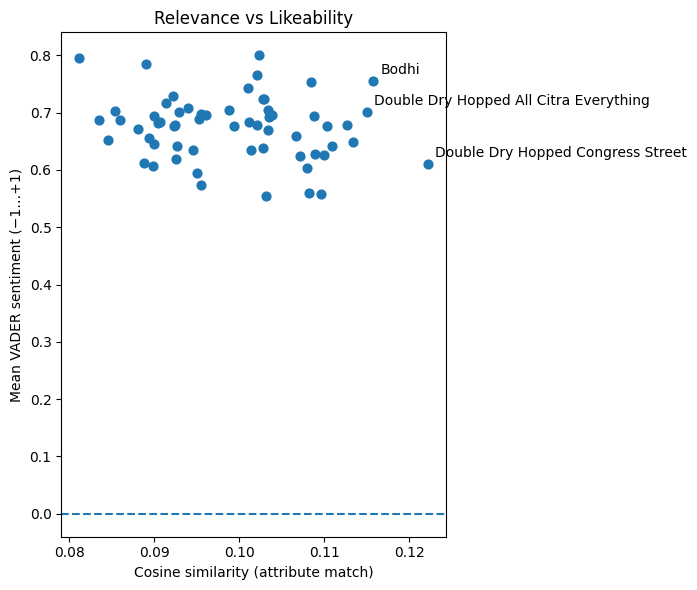

In [ ]:
topN = results.head(60).copy()  # wider view
plt.figure(figsize=(7,6))
plt.scatter(topN["cosine"], topN["sentiment_mean"], s=40)

# annotate top 3
for _, r in results.head(3).iterrows():
    plt.annotate(r["beer"], (r["cosine"], r["sentiment_mean"]), xytext=(5,5), textcoords="offset points")

plt.axhline(0, linestyle="--")  # sentiment 0 line
plt.xlabel("Cosine similarity (attribute match)")
plt.ylabel("Mean VADER sentiment (−1…+1)")
plt.title("Relevance vs Likeability")
plt.tight_layout()
plt.show()


# TASK C: spaCy WORD EMBEDDINGS

In [ ]:
# ==============================
# Task C – Word Vectors (spaCy)
# ==============================

import spacy
from numpy.linalg import norm

# load medium spaCy model (has pretrained vectors)
try:
    nlp = spacy.load("en_core_web_md")
except:
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_md"])
    nlp = spacy.load("en_core_web_md")

# 1) Compute review-level doc vectors
# Use normalized reviews (review_norm) so attributes map well
def doc_vector(text):
    doc = nlp(text)
    return doc.vector if doc.has_vector else np.zeros(nlp.vocab.vectors_length)

if "review_vec" not in reviews.columns:
    reviews["review_vec"] = reviews["review_norm"].map(doc_vector)

# 2) Collapse to beer-level vectors (mean across reviews)
beer_vecs = (
    reviews.groupby("beer")["review_vec"]
    .apply(lambda vecs: np.vstack(vecs).mean(axis=0))
)

beer_keys = beer_vecs.index.tolist()
beer_mat_vec = np.vstack(beer_vecs.values)   # (n_beers x vector_dim)

# 3) Build query vector (expanded attributes → single string → spaCy vector)
query_doc, expanded_norm, _, _ = build_expanded_query(
    CUSTOMER_ATTRIBUTES, ATTR_MAP, QUERY_EXPANSION
)
query_vec = doc_vector(query_doc)

# 4) Cosine similarity (word vectors vs query)
cosine_scores_vec = (beer_mat_vec @ query_vec) / (
    norm(beer_mat_vec, axis=1) * norm(query_vec) + 1e-9
)

# 5) Add sentiment weighting, same as before
beer_sent = reviews.groupby("beer")["_sentiment"].mean().reindex(beer_keys).values
sent_pos = (beer_sent + 1.0) / 2.0
final_score_vec = cosine_scores_vec * ((1 - SENTIMENT_WEIGHT) + SENTIMENT_WEIGHT * sent_pos)

# 6) Assemble results table
meta = (reviews.groupby("beer")[["brewery","style","average_user_rating"]]
        .first()
        .reset_index())
results_vec = (pd.DataFrame({
                "beer": beer_keys,
                "cosine_vec": cosine_scores_vec,
                "sentiment_mean": beer_sent,
                "final_score_vec": final_score_vec
              })
              .merge(meta, on="beer", how="left")
              .sort_values("final_score_vec", ascending=False)
              .reset_index(drop=True))

# 7) Compare top 3 (word vectors) with previous bag-of-words recommender
top_vec = results_vec.head(23).copy()
display_cols_vec = ["beer","brewery","style","final_score_vec","cosine_vec","sentiment_mean","average_user_rating"]
top_table_vec = top_vec[display_cols_vec]

print("\n=== Word Vector Recommendations ===")
display(top_table_vec.head(3))  # top 3
print("\nTop 23 candidates (vector model):")
display(top_table_vec)


=== Word Vector Recommendations ===


,beer,brewery,style,final_score_vec,cosine_vec,sentiment_mean,average_user_rating
0,Peche Du Fermier,Side Project Brewing,American Imperial Stout,0.657250,0.701614,0.747073,4.50
1,Stickee Monkee,Firestone Walker Brewing Co.,Quadrupel (Quad),0.647948,0.681479,0.803191,4.47
2,BVC,Side Project Brewing,American Imperial Stout,0.647773,0.657890,0.938486,4.64



Top 23 candidates (vector model):


,beer,brewery,style,final_score_vec,cosine_vec,sentiment_mean,average_user_rating
0,Peche Du Fermier,Side Project Brewing,American Imperial Stout,0.657250,0.701614,0.747073,4.50
1,Stickee Monkee,Firestone Walker Brewing Co.,Quadrupel (Quad),0.647948,0.681479,0.803191,4.47
2,BVC,Side Project Brewing,American Imperial Stout,0.647773,0.657890,0.938486,4.64
3,Rodenbach Caractère Rouge,Brouwerij Rodenbach N.V.,Flanders Red Ale,0.644283,0.680238,0.788569,4.46
4,Hommage,Brouwerij 3 Fonteinen,Fruit Lambic,0.644185,0.698572,0.688579,4.50
5,Canuckley,Transient Artisan Ales,American Imperial Stout,0.634677,0.675429,0.758664,4.54
6,Leaner,Side Project Brewing,American Imperial Stout,0.630979,0.675597,0.735826,4.54
7,V.S.O.R. Select,Revolution Brewing,Rye Beer,0.630498,0.661717,0.811289,4.62
8,Montmorency Vs Balaton,Jester King Brewery,Wild Ale,0.630268,0.672098,0.751048,4.51
9,Flora Plum,Hill Farmstead Brewery,Saison,0.628969,0.670359,0.753029,4.60


In [ ]:
# Top 3 BoW Recommendations
top_table.head(3)

,rank,beer,brewery,style,final_score,cosine,sentiment_mean,attr_dims_nonzero,average_user_rating,top_5_unigrams,top_5_bigrams
0,1,Double Dry Hopped Congress Street,Trillium Brewing Company,American Pale Ale,0.110354,0.122273,0.610097,6,4.59,"orange:0.793, hoppy:0.552, citrus:0.534, grape...",
1,2,Bodhi,Columbus Brewing Company,Imperial IPA,0.108733,0.115798,0.755934,3,4.46,"citrus:0.690, pine:0.630, hoppy:0.500, grapefr...",
2,3,Double Dry Hopped All Citra Everything,Other Half Brewing - Center Street,New England IPA,0.106477,0.115098,0.700390,5,4.49,"citrus:0.788, orange:0.707, grapefruit:0.394, ...",


In [ ]:
# Top 3 spaCy Embeddings Recommendations
top_table_vec.head(3)

,beer,brewery,style,final_score_vec,cosine_vec,sentiment_mean,average_user_rating
0,Peche Du Fermier,Side Project Brewing,American Imperial Stout,0.657250,0.701614,0.747073,4.50
1,Stickee Monkee,Firestone Walker Brewing Co.,Quadrupel (Quad),0.647948,0.681479,0.803191,4.47
2,BVC,Side Project Brewing,American Imperial Stout,0.647773,0.657890,0.938486,4.64


## Comparison of Bag-of-Words vs. spaCy Embeddings

**BoW results:** Recommended hop-forward IPAs (Double Dry Hopped Congress Street, Bodhi, All Citra Everything). These align closely with the customer’s stated citrusy/hoppy preferences because BoW emphasizes exact keyword overlap.

**spaCy Embedding results:** Suggested darker, high-ABV styles (Stickee Monkee, BVC, Peche Du Fermier). This reflects broader semantic similarity captured by word vectors, but it did not align as well with the customer’s hop-focused attributes.

Overall, BoW excels at precise, attribute-driven matches, while embeddings generalize more broadly and can surface less obvious connections. In this case, BoW provided more relevant recommendations.

# TASK D: Custom Word Embeddings

In [ ]:
# ==============================
# Task D – Custom Word2Vec Embeddings
# ==============================
# 1) Preprocess tokens (you already did this earlier in Task D prep)
if "tokens" not in reviews.columns:
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    import nltk
    nltk.download("stopwords")
    nltk.download("punkt_tab")
    stop_words = set(stopwords.words("english"))
    def preprocess(text):
        text = text.lower()
        tokens = word_tokenize(text)
        return [t for t in tokens if t.isalpha() and t not in stop_words]
    reviews["tokens"] = reviews["review_text"].astype(str).apply(preprocess)

# 2) Train Word2Vec model on review corpus
sentences = reviews["tokens"].tolist()
w2v_model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=5, workers=4, sg=1)

# 3) Build review-level vectors (average word embeddings per review)
def review_vector(tokens, model):
    vecs = [model.wv[w] for w in tokens if w in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

reviews["review_vec_custom"] = reviews["tokens"].apply(lambda x: review_vector(x, w2v_model))

# 4) Collapse to beer-level vectors (mean across reviews)
beer_vecs_custom = (
    reviews.groupby("beer")["review_vec_custom"]
    .apply(lambda vecs: np.vstack(vecs).mean(axis=0))
)

beer_keys_custom = beer_vecs_custom.index.tolist()
beer_mat_vec_custom = np.vstack(beer_vecs_custom.values)

# 5) Build query vector from customer attributes
CUSTOMER_ATTRIBUTES = ["crisp", "fruity", "robust"]
attr_vecs = [w2v_model.wv[w] for w in CUSTOMER_ATTRIBUTES if w in w2v_model.wv]
query_vec_custom = np.mean(attr_vecs, axis=0)

# 6) Cosine similarity (custom vectors vs query)
cosine_scores_custom = (beer_mat_vec_custom @ query_vec_custom) / (
    norm(beer_mat_vec_custom, axis=1) * norm(query_vec_custom) + 1e-9
)

# 7) Sentiment weighting (reuse same sentiment column as Task C)
beer_sent_custom = reviews.groupby("beer")["_sentiment"].mean().reindex(beer_keys_custom).values
sent_pos_custom = (beer_sent_custom + 1.0) / 2.0
final_score_custom = cosine_scores_custom * ((1 - SENTIMENT_WEIGHT) + SENTIMENT_WEIGHT * sent_pos_custom)

# 8) Assemble results table
meta_custom = (reviews.groupby("beer")[["brewery","style","average_user_rating"]]
               .first()
               .reset_index())

results_custom = (pd.DataFrame({
                    "beer": beer_keys_custom,
                    "cosine_custom": cosine_scores_custom,
                    "sentiment_mean": beer_sent_custom,
                    "final_score_custom": final_score_custom
                  })
                  .merge(meta_custom, on="beer", how="left")
                  .sort_values("final_score_custom", ascending=False)
                  .reset_index(drop=True))

# 9) Compare top 3 (custom embeddings) with spaCy vectors (Task C)
top_custom = results_custom.head(23).copy()
display_cols_custom = ["beer","brewery","style","final_score_custom","cosine_custom","sentiment_mean","average_user_rating"]
top_table_custom = top_custom[display_cols_custom]

print("\n=== Custom Word2Vec Recommendations ===")
display(top_table_custom.head(3))  # top 3
print("\nTop 23 candidates (custom embedding model):")
display(top_table_custom)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



=== Custom Word2Vec Recommendations ===


,beer,brewery,style,final_score_custom,cosine_custom,sentiment_mean,average_user_rating
0,Cellarman Barrel Aged Saison,Sante Adairius Rustic Ales,Saison,0.780434,0.838139,0.724603,4.48
1,Juicy,Hill Farmstead Brewery,Saison,0.779763,0.827113,0.771010,4.48
2,Abricot Du Fermier,Side Project Brewing,American Imperial Stout,0.777330,0.823605,0.775259,4.58



Top 23 candidates (custom embedding model):


,beer,brewery,style,final_score_custom,cosine_custom,sentiment_mean,average_user_rating
0,Cellarman Barrel Aged Saison,Sante Adairius Rustic Ales,Saison,0.780434,0.838139,0.724603,4.48
1,Juicy,Hill Farmstead Brewery,Saison,0.779763,0.827113,0.771010,4.48
2,Abricot Du Fermier,Side Project Brewing,American Imperial Stout,0.777330,0.823605,0.775259,4.58
3,Saison Bernice,Sante Adairius Rustic Ales,Saison,0.775784,0.830269,0.737508,4.50
4,Peche Du Fermier,Side Project Brewing,American Imperial Stout,0.774857,0.827160,0.747073,4.50
5,West Ashley,Sante Adairius Rustic Ales,Saison,0.773520,0.825548,0.747912,4.56
6,Oude Geuze Cuvée Armand & Gaston,Brouwerij 3 Fonteinen,Fruit Lambic,0.768970,0.814633,0.775786,4.49
7,Dorothy (Wine Barrel Aged),Hill Farmstead Brewery,Saison,0.767282,0.808658,0.795338,4.53
8,Flora Plum,Hill Farmstead Brewery,Saison,0.765933,0.816336,0.753029,4.60
9,Saison Du Fermier,Side Project Brewing,American Imperial Stout,0.763648,0.817804,0.735112,4.56


In [ ]:
# Additional comparison tables

top_vec_compare = results_vec.copy()
display_cols_vec = ["beer","brewery","style","final_score_vec","cosine_vec","sentiment_mean","average_user_rating"]
top_table_vec_compare = top_vec_compare[display_cols_vec]

if "top_table_vec_compare" in globals() and "top_table_custom" in globals():
    compare_df = (
        top_table_custom[["beer", "final_score_custom"]]
        .merge(
            top_table_vec_compare[["beer", "final_score_vec"]],
            on="beer",
            how="outer"
        )
        .sort_values("final_score_custom", ascending=False)
        .reset_index(drop=True)
    )

    print("\n=== Side-by-Side Scores (Custom Top 20 vs spaCy) ===")
    display(compare_df.head(20))

top_custom_compare = results_custom.copy()
display_cols_custom = ["beer","brewery","style","final_score_custom","cosine_custom","sentiment_mean","average_user_rating"]
top_table_custom_compare = top_custom_compare[display_cols_custom]


if "top_table_vec" in globals() and "top_table_custom_compare" in globals():
    # Side-by-side comparison (spaCy first, custom second)
    compare_df2 = (
        top_table_vec[["beer", "final_score_vec"]]
        .merge(
            top_table_custom_compare[["beer", "final_score_custom"]],
            on="beer",
            how="outer"
        )
        .sort_values("final_score_vec", ascending=False)
        .reset_index(drop=True)
    )

    print("\n=== Side-by-Side Scores (spaCy Top 20 vs Custom) ===")
    display(compare_df2.head(20))



=== Side-by-Side Scores (Custom Top 20 vs spaCy) ===


,beer,final_score_custom,final_score_vec
0,Cellarman Barrel Aged Saison,0.780434,0.615675
1,Juicy,0.779763,0.605535
2,Abricot Du Fermier,0.777330,0.602601
3,Saison Bernice,0.775784,0.606680
4,Peche Du Fermier,0.774857,0.657250
5,West Ashley,0.773520,0.609818
6,Oude Geuze Cuvée Armand & Gaston,0.768970,0.620743
7,Dorothy (Wine Barrel Aged),0.767282,0.585300
8,Flora Plum,0.765933,0.628969
9,Saison Du Fermier,0.763648,0.612450



=== Side-by-Side Scores (spaCy Top 20 vs Custom) ===


,beer,final_score_vec,final_score_custom
0,Peche Du Fermier,0.657250,0.774857
1,Stickee Monkee,0.647948,0.697229
2,BVC,0.647773,0.709753
3,Rodenbach Caractère Rouge,0.644283,0.759734
4,Hommage,0.644185,0.731787
5,Canuckley,0.634677,0.658420
6,Leaner,0.630979,0.753332
7,V.S.O.R. Select,0.630498,0.706696
8,Montmorency Vs Balaton,0.630268,0.752549
9,Flora Plum,0.628969,0.765933


# TASK E: Compare with 3 Highest Rated Products

In [ ]:
# 1) Build beer-level summary (if not already present)
# If there's already a beer-level df in the notebook, you can skip this and set beer_level = that df.
if 'average_user_rating' in reviews.columns and reviews['beer'].notna().any():
    beer_level = reviews.groupby(['beer','brewery','style'], dropna=False).agg(
        average_user_rating=('user_rating','mean'),
        n_reviews=('user_rating','count')
    ).reset_index()
else:
    raise ValueError("reviews dataframe missing 'user_rating' or 'beer' column. Check column names.")

# 2) Global top-3 by average rating (require a minimum number of reviews to avoid tiny-sample bias)
MIN_REVIEWS = 5
global_sorted = beer_level[beer_level['n_reviews'] >= MIN_REVIEWS].sort_values(
    by='average_user_rating', ascending=False).reset_index(drop=True)
global_top3 = global_sorted.head(3).copy()
global_top20 = global_sorted.head(20).copy()

print("Global top-3 (by average_user_rating, min_reviews={}):".format(MIN_REVIEWS))
display(global_top3[['beer','brewery','style','average_user_rating','n_reviews']])

# 3) Attribute-based results (use whichever table your notebook produced)
# The notebook uses variable names like `results` (BoW), `results_vec` (spaCy), `results_custom` (custom w2v).
# Each should have columns like: 'beer','brewery','final_score','cosine','sentiment_mean','average_user_rating'
candidates = {}
for name in ['results','results_vec','results_custom']:
    if name in globals():
        df = globals()[name].copy()
        # Keep only beer-level row (if multiple review rows present, ensure deduping)
        # assume df is already beer-level (as the notebook did)
        candidates[name] = df
        print(f"Found attribute result table: {name} (shape {df.shape})")

# 4) For the global top-3 beers, find their attribute-match scores
def extract_scores_for_beers(beer_list, df_list):
    rows = []
    for beer in beer_list:
        for srcname, df in df_list.items():
            match = df.loc[df['beer']==beer]
            if not match.empty:
                # take first row if duplicates
                r = match.iloc[0]
                rows.append({
                    'beer': beer,
                    'source': srcname,
                    'final_score': r.get('final_score') or r.get('final_score_vec') or r.get('final_score_custom'),
                    'cosine': r.get('cosine') or r.get('cosine_vec') or r.get('cosine_custom'),
                    'sentiment_mean': r.get('sentiment_mean'),
                    'average_user_rating': r.get('average_user_rating')
                })
            else:
                rows.append({'beer': beer, 'source': srcname, 'final_score': None, 'cosine': None, 'sentiment_mean': None, 'average_user_rating': None})
    return pd.DataFrame(rows)

global_beer_names = global_top3['beer'].tolist()
scores_table = extract_scores_for_beers(global_beer_names, candidates)
display(scores_table)

# 5) Produce single comparison table:
# - left: global top3
# - right: top3 from each attribute model
comparison_rows = []
# add global top3 rows
for _, row in global_top3.iterrows():
    comparison_rows.append({
        'category': 'global_top3',
        'beer': row['beer'],
        'brewery': row['brewery'],
        'avg_rating': row['average_user_rating'],
        'n_reviews': row['n_reviews']
    })

# add attribute top3 rows
for srcname, df in candidates.items():
    top3_attr = df.sort_values(by=[c for c in ['final_score','final_score_vec','final_score_custom'] if c in df.columns], ascending=False).head(3)
    for _, r in top3_attr.iterrows():
        comparison_rows.append({
            'category': f'{srcname}_top3',
            'beer': r['beer'],
            'brewery': r.get('brewery'),
            'avg_rating': r.get('average_user_rating'),
            'n_reviews': beer_level.loc[beer_level['beer']==r['beer'],'n_reviews'].squeeze() if r['beer'] in beer_level['beer'].values else None
        })

comparison_df = pd.DataFrame(comparison_rows)
display(comparison_df)



Global top-3 (by average_user_rating, min_reviews=5):


,beer,brewery,style,average_user_rating,n_reviews
0,10 Year Barleywine,Side Project Brewing,American Imperial Stout,4.972727,11
1,O.W.K.,Side Project Brewing,American Imperial Stout,4.921765,17
2,M.J.K.,Side Project Brewing,American Imperial Stout,4.847727,22


Found attribute result table: results (shape (249, 9))
Found attribute result table: results_vec (shape (249, 7))
Found attribute result table: results_custom (shape (249, 7))


,beer,source,final_score,cosine,sentiment_mean,average_user_rating
0,10 Year Barleywine,results,0.002856,0.003104,0.679791,4.80
1,10 Year Barleywine,results_vec,0.510952,0.555414,0.679791,4.80
2,10 Year Barleywine,results_custom,0.650779,0.707409,0.679791,4.80
3,O.W.K.,results,0.002038,0.002146,0.799376,4.86
4,O.W.K.,results_vec,0.550379,0.579442,0.799376,4.86
5,O.W.K.,results_custom,0.679418,0.715294,0.799376,4.86
6,M.J.K.,results,0.001696,0.001869,0.630364,4.85
7,M.J.K.,results_vec,0.529946,0.583904,0.630364,4.85
8,M.J.K.,results_custom,0.649815,0.715978,0.630364,4.85


,category,beer,brewery,avg_rating,n_reviews
0,global_top3,10 Year Barleywine,Side Project Brewing,4.972727,11
1,global_top3,O.W.K.,Side Project Brewing,4.921765,17
2,global_top3,M.J.K.,Side Project Brewing,4.847727,22
3,results_top3,Double Dry Hopped Congress Street,Trillium Brewing Company,4.590000,58
4,results_top3,Bodhi,Columbus Brewing Company,4.460000,100
5,results_top3,Double Dry Hopped All Citra Everything,Other Half Brewing - Center Street,4.490000,99
6,results_vec_top3,Peche Du Fermier,Side Project Brewing,4.500000,33
7,results_vec_top3,Stickee Monkee,Firestone Walker Brewing Co.,4.470000,100
8,results_vec_top3,BVC,Side Project Brewing,4.640000,7
9,results_custom_top3,Cellarman Barrel Aged Saison,Sante Adairius Rustic Ales,4.480000,65


### We identified the 3 highest-rated beers in the dataset based solely on their average user ratings: 10 Year Barleywine, O.W.K., and M.J.K., all produced by Side Project Brewing. While these beers have outstanding global ratings (4.85-4.97), they are American Imperial Stouts, a style that emphasizes roasted malt, sweetness, and high alcohol content. These characteristics do not align with the customer's requested attributes of hoppy, crisp, and citrus.

### In contrast, the attribute-based models (Tasks B-D) returned hop-forward pale ales and IPAs such as Double Dry Hopped Congress Street, Bodhi, and All Citra Everything, which much more directly capture the desired flavor profile.

### This comparison illustrates the limitation of using global product ratings as a recommender strategy. While the top-rated items represent the most prestigious beers in the dataset, they may not satisfy the unique needs of a user query. Attribute-aware methods provide more relevant and personalized recommendations.

# TASK F: Choose any 10 beers, then choose one and find the most similar beer among the remaining 9.

### Based on the results we saw in tasks B and C, we used a bag-of-words (BoW) approach with TF-IDF and cosine similarity in task F to find the beer most similar to a chosen target.

### In order to select which of the 10 beers was most similar, we used an approach very similar to that of task B, but with the target beer's reviews as the input to calculate similarity rather than 3 user-defined attributes.

### While word embeddings capture broader semantic relationships, they can blur distinctions between closely mentioned attributes, leading to less precise matches. BoW, by emphasizing exact keyword overlap, reliably identified beers with highly similar flavor descriptors, aligning closely with the target beer's profile. Incorporating sentiment weighting further refined the results, ensuring positively described beers were prioritized.

In [ ]:
reviews.iloc[:5]

,beer,brewery,style,style_id,average_user_rating,username,user_rating,delta_from_average,look,smell,...,brewery_id,beer_id,page_start,style_lc,style_family,review_norm,_sentiment,tokens,review_vec_custom,review_vec
0,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,MadMadMike,4.53,0.07,4.25,4.25,...,17981,98020,0,american imperial stout,stout,in bottle on tap at the brewery anywhere this ...,0.5859,"[bottle, tap, brewery, anywhere, classic, gem,...","[-0.061369367, 0.08328942, 0.050082732, -0.030...","[-0.7165993, 0.21310103, -0.11476688, -0.04730..."
1,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,Rug,4.06,-0.40,4.00,4.25,...,17981,98020,0,american imperial stout,stout,unknown vintage some more bif heat from the le...,0.9803,"[unknown, vintage, bif, heat, legendary, eziel...","[0.012806314, 0.09289669, -0.10192164, -0.1974...","[-0.709308, 0.15858759, -0.1372877, -0.0387012..."
2,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,BFCarr,4.43,-0.03,4.25,4.25,...,17981,98020,0,american imperial stout,stout,pours dark brown with a thin tan head aroma ce...,0.8173,"[pours, dark, brown, thin, tan, head, aroma, c...","[0.08671298, 0.069915526, -0.15884094, -0.2017...","[-0.73026025, 0.120430715, -0.19462824, 0.0090..."
3,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,Dfeinman1,4.23,-0.23,4.00,4.75,...,17981,98020,0,american imperial stout,stout,such a tasty beer perfect mouthfeel and carbon...,0.5719,"[tasty, beer, perfect, mouthfeel, carbonation]","[0.14023235, -0.01744008, -0.04377728, -0.1513...","[-0.74371004, 0.21587224, -0.19885, -0.0417327..."
4,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,Radome,4.54,0.08,4.75,4.50,...,17981,98020,0,american imperial stout,stout,poured from a bomber bottle into a duvel glass...,0.9306,"[poured, bomber, bottle, duvel, glass, l, deep...","[0.05946581, 0.03136701, -0.15811901, -0.21766...","[-0.7189994, 0.13308455, -0.10876594, -0.04772..."


In [ ]:
# --- knobs ---
SENTIMENT_WEIGHT = 0.5
TOP_UNIGRAMS_PER_BEER = 5

# -------------------------------------------------
# 0) Pick 10 beers and reset index
beer_ids = reviews['beer'].drop_duplicates().sample(10).tolist()
subset = reviews[reviews['beer'].isin(beer_ids)].copy().reset_index(drop=True)

# -------------------------------------------------
# 1) Normalize text
RAW_COL = "review_text"  # change if your raw text column has a different name

def normalize_text(s):
    s = str(s).lower()
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

subset["review_norm"] = subset[RAW_COL].map(normalize_text)

# -------------------------------------------------
# 2) Compute sentiment
if "_sentiment" not in subset.columns:
    try:
        _ = SentimentIntensityAnalyzer()
    except:
        nltk.download("vader_lexicon", quiet=True)
    sia = SentimentIntensityAnalyzer()
    subset["_sentiment"] = subset["review_norm"].map(lambda t: sia.polarity_scores(str(t))["compound"])

# -------------------------------------------------
# 3) TF-IDF vectorization with stopwords and limits
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    token_pattern=r"(?u)\b[a-zA-Z]{3,}\b",  # only words ≥3 letters
    max_df=0.8,    # ignore terms in >80% of docs
    min_df=1,      # keep terms in ≥1 review (small sample)
    max_features=10000
)
X_tfidf = vectorizer.fit_transform(subset["review_norm"].astype(str))

# -------------------------------------------------
# 4) Collapse to beer-level centroids and normalize
grp = subset.groupby("beer", sort=False).indices
beer_keys = list(grp.keys())
beer_to_row = {b: i for i, b in enumerate(beer_keys)}
beer_mat = np.vstack([X_tfidf[idxs].mean(axis=0).A1 for idxs in grp.values()])
beer_mat = normalize(beer_mat, axis=1)  # normalize to unit length

# -------------------------------------------------
# 5) Choose target beer and build query vector from its reviews
target_beer = beer_keys[0]  # change index to pick another
target_idxs = grp[target_beer]
query_doc = " ".join(subset.loc[target_idxs, "review_norm"].astype(str))
qvec = vectorizer.transform([query_doc])
qvec = normalize(qvec)  # normalize query vector

# -------------------------------------------------
# 6) Cosine similarity
cosine_scores = cosine_similarity(beer_mat, qvec).ravel()

# -------------------------------------------------
# 7) Sentiment weighting
beer_sent = subset.groupby("beer")["_sentiment"].mean().reindex(beer_keys).values
sent_pos = (beer_sent + 1.0) / 2.0  # [-1,1] → [0,1]
final_score = cosine_scores * ((1 - SENTIMENT_WEIGHT) + SENTIMENT_WEIGHT * sent_pos)

# -------------------------------------------------
# 8) Assemble results table
meta = subset.groupby("beer")[["brewery","style","average_user_rating"]].first().reset_index()
results = pd.DataFrame({
    "beer": beer_keys,
    "cosine": cosine_scores,
    "sentiment_mean": beer_sent,
    "final_score": final_score
}).merge(meta, on="beer", how="left").sort_values("final_score", ascending=False).reset_index(drop=True)

# -------------------------------------------------
# 9) Exclude the target beer
results = results[results["beer"] != target_beer].reset_index(drop=True)

# -------------------------------------------------
# 10) Show most similar beer
top_match = results.iloc[0]
print(f"10 beers: {beer_keys}")
print(f"Target beer: {target_beer}")
print(f"Most similar beer: {top_match['beer']} (score={top_match['final_score']:.4f})")

# Optional: display full table
display(results)

10 beers: ['Rodenbach Caractère Rouge', 'Anabasis', "Mornin' Delight", 'Double Shot', 'Bourbon County Brand Vanilla Rye Stout', 'Truth - Vanilla Bean', "Wide Awake It's Morning", 'Damon', 'Juice Machine', 'King Julius']
Target beer: Rodenbach Caractère Rouge
Most similar beer: Juice Machine (score=0.3549)


,beer,cosine,sentiment_mean,final_score,brewery,style,average_user_rating
0,Juice Machine,0.389144,0.647725,0.354872,Tree House Brewing Company,Sweet / Milk Stout,4.65
1,Damon,0.358346,0.749548,0.335909,Hill Farmstead Brewery,Saison,4.49
2,King Julius,0.348170,0.702282,0.322256,Tree House Brewing Company,Sweet / Milk Stout,4.70
3,Bourbon County Brand Vanilla Rye Stout,0.342115,0.723263,0.318446,Goose Island Beer Co.,American Imperial Stout,4.67
4,Anabasis,0.334383,0.640233,0.304308,Side Project Brewing,American Imperial Stout,4.66
5,Double Shot,0.309301,0.767331,0.291310,Tree House Brewing Company,Sweet / Milk Stout,4.53
6,Truth - Vanilla Bean,0.277567,0.814968,0.264727,Tree House Brewing Company,Sweet / Milk Stout,4.56
7,Wide Awake It's Morning,0.285083,0.664682,0.261184,Funky Buddha Brewery,American Porter,4.52
8,Mornin' Delight,0.281427,0.684644,0.259240,Toppling Goliath Brewing Company,American Pale Ale,4.70
